In [1]:
# Setup access to my Google Drive
from google.colab import drive
drive.mount('/content/drive',  force_remount=False)

# Set the working directory
import os
os.chdir('/content/drive/MyDrive/ViT_myWorks/')
import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [2]:
!pip install -q torchmetrics
!pip install --upgrade pytorch-pretrained-vit
!pip install efficientnet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-pretrained-vit: filename=pytorch_pretrained_vit-0.0.7-py3-none-any.whl size=11116 sha256=52705fbf9c2cb0b1ba07c3a668e4cdac5eb841dc3a1ae1da81087746eb3b4a8b
  Stored in directory: /root/.cache/pip/wheels/2d/46/ad/12007be9d377d0fbf27ef75b6e47ed92832ab6b70dbf004b6f
Successfully built pytorch-pretrained-vit
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=51c222736b07e991fc3494316562e82fc789f0550dd90590b8ab70be887594af
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [1]:
# from sklearn.manifold import TSNE
# from sklearn.metrics import f1_score, precision_score, recall_score
# import matplotlib.pyplot as plt
# import pandas as pd
# import seaborn as sn
# import numpy as np
# import random
import torch
# import torch.nn as nn
# import torchvision.transforms as transforms
# from torchvision.utils import make_grid
# from torch.utils.data import Dataset, DataLoader
# import PIL.Image as Image
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
# import math
# import scipy.io as sio
from efficientnet_pytorch import EfficientNet

In [2]:
from resViT.model import *
from resViT.train import *
from resViT.loaddata import *

In [3]:
root = './PBU_400/' #running from local
tarData = [f[:-4] for f in os.listdir(root+'tar3/') if f.endswith('.mat')]
class_names = ['H', 'OR', 'IR']
img_size=128

# Proposed ViT

In [6]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

for fcase in ['tar3', 'tar4']:
    for tar in range(len(tarData)):
        root_path = root + fcase + '/'
        TrainLoader, TestLoader, ValLoader, numClass = loaddata(root_path, tarData[tar])
        Model = torch.load('./saved_models/ViT_src_7_0.pth', map_location=device)
        Model.fc = MyFC(numClass)
        optC = torch.optim.Adam(Model.parameters(), lr=0.00001)
        criterion = nn.CrossEntropyLoss() #Define classification loss
        print(f'Fine tuning model for traget data: {fcase}_{tarData[tar]}')
        Model = train_pr(Model, TrainLoader, ValLoader, optC, criterion)
        torch.save(Model,'./saved_models/ViT_'+ fcase+ '_' + tarData[tar]+'.pth')

Fine tuning model for traget data: tar3_tarData_1
Starting Training Loop...
[0/20]   Train Accuracy = 76.50    Val Accuracy = 66.46
[1/20]   Train Accuracy = 88.15    Val Accuracy = 69.91
[2/20]   Train Accuracy = 95.60    Val Accuracy = 79.62
[3/20]   Train Accuracy = 93.73    Val Accuracy = 88.57
[4/20]   Train Accuracy = 97.06    Val Accuracy = 96.79
[5/20]   Train Accuracy = 96.12    Val Accuracy = 96.99
[6/20]   Train Accuracy = 96.81    Val Accuracy = 98.37
[7/20]   Train Accuracy = 96.97    Val Accuracy = 97.53
[8/20]   Train Accuracy = 97.47    Val Accuracy = 96.70
[9/20]   Train Accuracy = 99.05    Val Accuracy = 98.10
[10/20]   Train Accuracy = 98.39    Val Accuracy = 97.42
[11/20]   Train Accuracy = 98.82    Val Accuracy = 97.03
[12/20]   Train Accuracy = 98.63    Val Accuracy = 97.46
[13/20]   Train Accuracy = 98.29    Val Accuracy = 96.63
[14/20]   Train Accuracy = 98.49    Val Accuracy = 96.47
[15/20]   Train Accuracy = 98.87    Val Accuracy = 98.23
[16/20]   Train Accura

Validation Accuracy =  99.16666666666667
__________________________________________________
Pricision Score = 0.9925925925925926
__________________________________________________
F_1 Score =  0.990194075587334
__________________________________________________
Recall Score =  0.9880952380952381
__________________________________________________
Response time per batch 0.6227715015411377
Validation Accuracy =  100.0
__________________________________________________
Pricision Score = 1.0
__________________________________________________
F_1 Score =  1.0
__________________________________________________
Recall Score =  1.0
__________________________________________________
Response time per batch 0.5938634872436523
Validation Accuracy =  100.0
__________________________________________________
Pricision Score = 1.0
__________________________________________________
F_1 Score =  1.0
__________________________________________________
Recall Score =  1.0
_________________________________

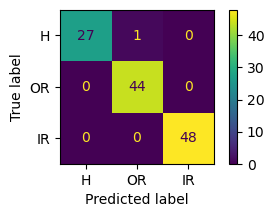

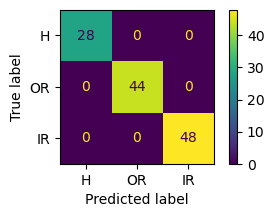

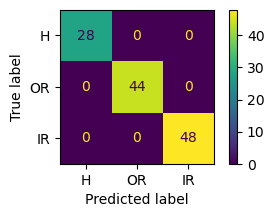

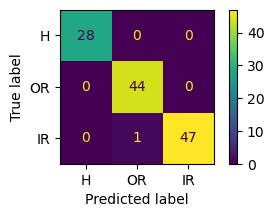

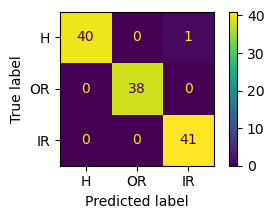

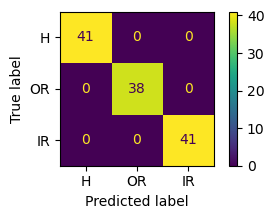

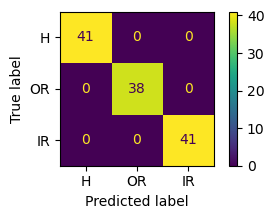

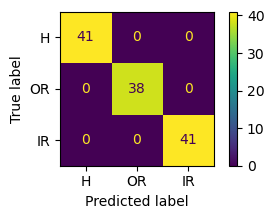

In [8]:
# Validate and Visualize
perfvit = pd.DataFrame({'Metrics':['Val Acc.', 'Precision', 'F1_score', 'Recall']})
for fcase in ['tar3', 'tar4']:
    for tar in range(len(tarData)):
        root_path = root + fcase + '/'
        Model = torch.load('./saved_models/ViT_'+ fcase+ '_' + tarData[tar]+'.pth', map_location=device)
        _, TestLoader, _, numClass = loaddata(root_path, tarData[0])
        val_acc, cm, prec, f1, recall, time_batch, _, _ = validate_pr(Model, TestLoader, numClass)
        print('Validation Accuracy = ', 100*val_acc)
        print("__________________________________________________")
        print(f'Pricision Score = {prec}')
        print('__________________________________________________')
        print(f'F_1 Score =  {f1}')
        print('__________________________________________________')
        print(f"Recall Score =  {recall}")
        print('__________________________________________________')
        print('Response time per batch', time_batch)
        disp_conf_matrix(cm, class_names)

        perfvit = pd.concat((perfvit, pd.DataFrame({fcase+ '_' + str(tar) : [100*val_acc, prec, f1, recall]})), ignore_index = True, axis=1)

# Train benchmark models for comparisions
## Models: EfficientNet, ResNeXt, DenseNet, VGGNet, GoogleNet, SqeezeNet

### Standard ViT wth 12 encoder block pre-trained in ImageNet1k

In [8]:
for fcase in ['tar3', 'tar4']:
    for tar in range(len(tarData)):
        root_path = root + fcase + '/'
        TrainLoader, TestLoader, ValLoader, numClass = loaddata(root_path, tarData[tar])
        Model = ViTpretrain(img_size, numClass)
        Model.to(device)
        optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
        criterion = nn.CrossEntropyLoss()
        print(f'Fine tuning pre-trained ViT model for traget data: {fcase}_{tarData[tar]}')
        Model = train(Model, TrainLoader, ValLoader, optC, criterion)
        torch.save(Model,'./saved_models/ViT_pre_'+fcase+ '_' + tarData[tar]+'.pth')

Downloading: "https://github.com/lukemelas/PyTorch-Pretrained-ViT/releases/download/0.0.2/B_16_imagenet1k.pth" to /root/.cache/torch/hub/checkpoints/B_16_imagenet1k.pth
100%|██████████| 331M/331M [00:01<00:00, 233MB/s]


Resized positional embeddings from torch.Size([1, 577, 768]) to torch.Size([1, 65, 768])
Loaded pretrained weights.
Fine tuning pre-trained ViT model for traget data: tar3_tarData_1
Starting Training Loop...
[0/20]   Train Accuracy = 66.93    Val Accuracy = 81.25
[1/20]   Train Accuracy = 71.88    Val Accuracy = 70.83
[2/20]   Train Accuracy = 86.20    Val Accuracy = 78.12
[3/20]   Train Accuracy = 94.01    Val Accuracy = 96.88
[4/20]   Train Accuracy = 98.44    Val Accuracy = 93.75
[5/20]   Train Accuracy = 98.18    Val Accuracy = 90.62
[6/20]   Train Accuracy = 98.70    Val Accuracy = 91.67
[7/20]   Train Accuracy = 98.96    Val Accuracy = 93.75
[8/20]   Train Accuracy = 100.00    Val Accuracy = 91.67
[9/20]   Train Accuracy = 100.00    Val Accuracy = 94.79
[10/20]   Train Accuracy = 98.96    Val Accuracy = 90.62
[11/20]   Train Accuracy = 100.00    Val Accuracy = 84.38
[12/20]   Train Accuracy = 99.48    Val Accuracy = 65.62
[13/20]   Train Accuracy = 97.92    Val Accuracy = 82.29
[

Validation Accuracy =  97.1875
__________________________________________________
Pricision Score = 0.9744990303813834
__________________________________________________
F_1 Score =  0.9716382520845956
__________________________________________________
Recall Score =  0.9703767123287671
__________________________________________________
Response time per batch 0.011122703552246094


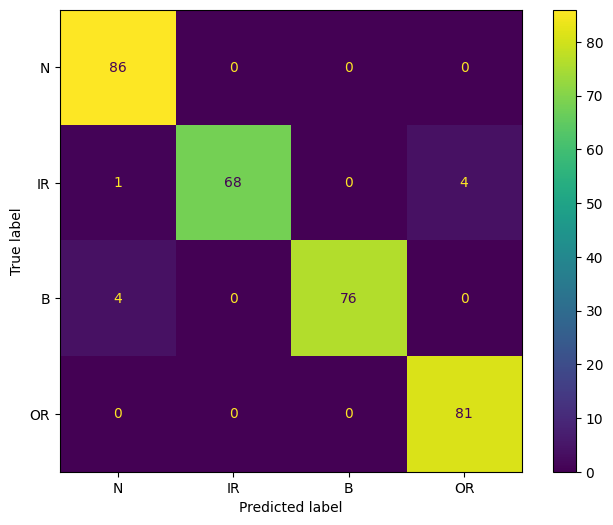

In [ ]:
# Validate and Visualize
Model = torch.load('./saved_models/ViT_pre_' +fcase+ '_' +tarData[0]+'.pth', map_location=device)
TrainLoader, TestLoader, ValLoader, numClass = loaddata(root_path, tarData[0])
val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader, 4)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm)

perfvit_pre = {'Modelname':['ViT_pre_'+tarData[tar]], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

### EfficientNet

In [ ]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

for fcase in ['tar3', 'tar4']:
  for tar in range(len(tarData)):
      root_path = root + fcase + '/'
      TrainLoader, TestLoader, ValLoader, numClass = loaddata(root_path, tarData[tar])
      Model = EfficientNet.from_pretrained('efficientnet-b1')
      Model._fc = EffNetFC(numClass)
      Model.to(device)
      optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
      criterion = nn.CrossEntropyLoss()
      print(f'Fine tuning EfficentNet model for traget data: {fcase}_{tarData[tar]}')
      Model = train(Model, TrainLoader, ValLoader, optC, criterion)
      torch.save(Model,'./saved_models/efficient_'+fcase+ '_' + tarData[tar]+'.pth')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 211MB/s]


Loaded pretrained weights for efficientnet-b1
Fine tuning EfficentNet model for traget data: tar3_tarData_1
Starting Training Loop...
[0/20]   Train Accuracy = 35.68    Val Accuracy = 38.54
[1/20]   Train Accuracy = 41.15    Val Accuracy = 51.04
[2/20]   Train Accuracy = 55.47    Val Accuracy = 57.29
[3/20]   Train Accuracy = 64.32    Val Accuracy = 61.46
[4/20]   Train Accuracy = 68.75    Val Accuracy = 64.58
[5/20]   Train Accuracy = 75.00    Val Accuracy = 69.79
[6/20]   Train Accuracy = 81.77    Val Accuracy = 76.04
[7/20]   Train Accuracy = 88.54    Val Accuracy = 85.42
[8/20]   Train Accuracy = 96.35    Val Accuracy = 84.38
[9/20]   Train Accuracy = 97.92    Val Accuracy = 86.46
[10/20]   Train Accuracy = 99.22    Val Accuracy = 90.62
[11/20]   Train Accuracy = 99.48    Val Accuracy = 85.42
[12/20]   Train Accuracy = 96.61    Val Accuracy = 84.38
[13/20]   Train Accuracy = 97.66    Val Accuracy = 90.62
[14/20]   Train Accuracy = 99.74    Val Accuracy = 92.71
[15/20]   Train Accur

Validation Accuracy =  94.16666666666667
__________________________________________________
Pricision Score = 0.9447054250652451
__________________________________________________
F_1 Score =  0.9468402188266364
__________________________________________________
Recall Score =  0.9501262626262627
__________________________________________________
Response time per batch
 0.12153434753417969
Validation Accuracy =  89.55223880597015
__________________________________________________
Pricision Score = 0.898328323577493
__________________________________________________
F_1 Score =  0.8960240270585099
__________________________________________________
Recall Score =  0.8998917748917749
__________________________________________________
Response time per batch
 0.13301515579223633
Validation Accuracy =  85.83333333333333
__________________________________________________
Pricision Score = 0.8890472796388691
__________________________________________________
F_1 Score =  0.8514919993817344
_

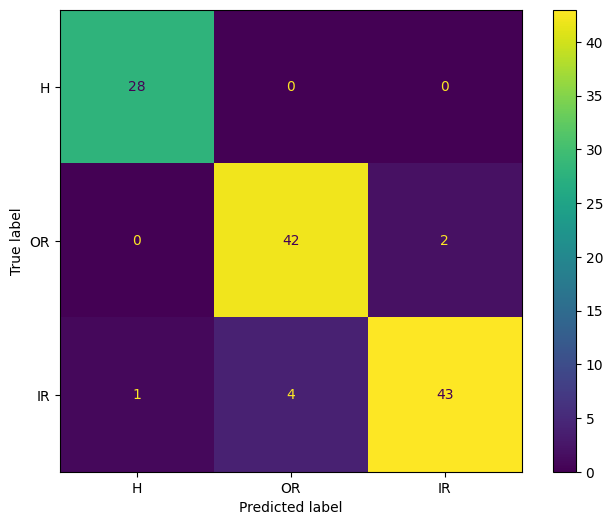

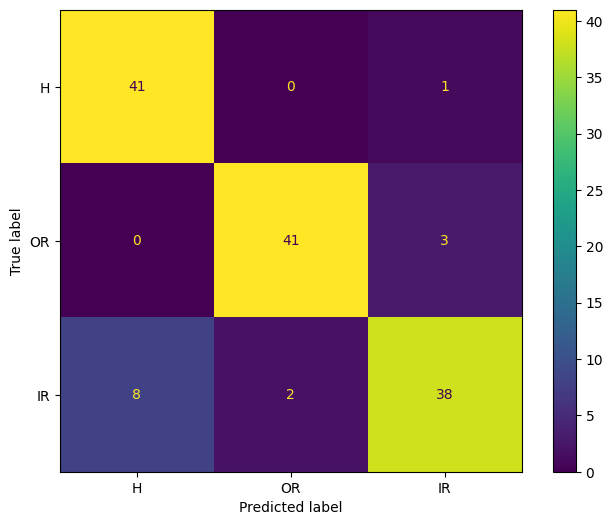

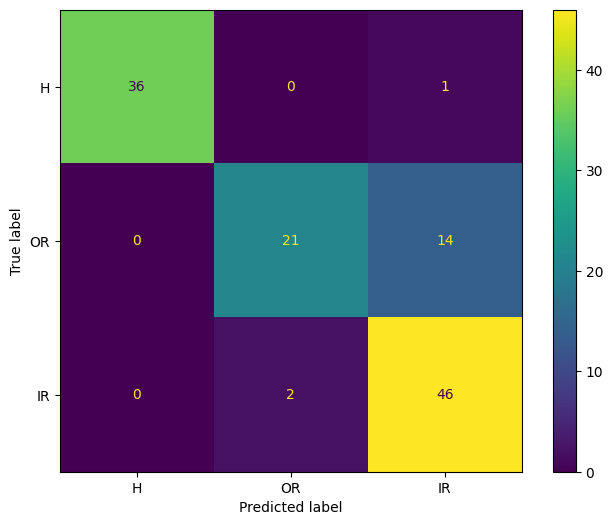

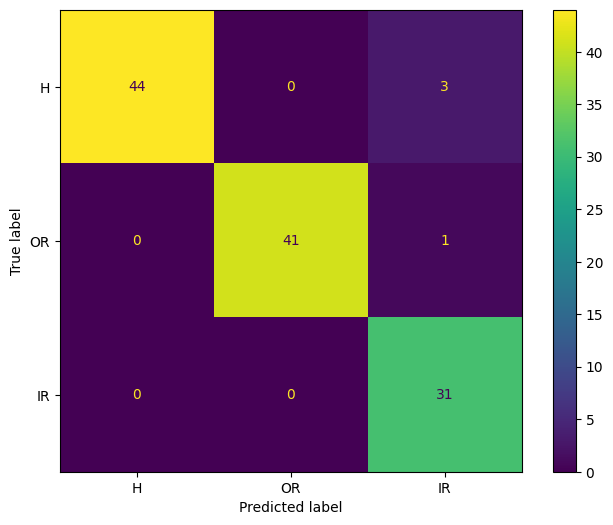

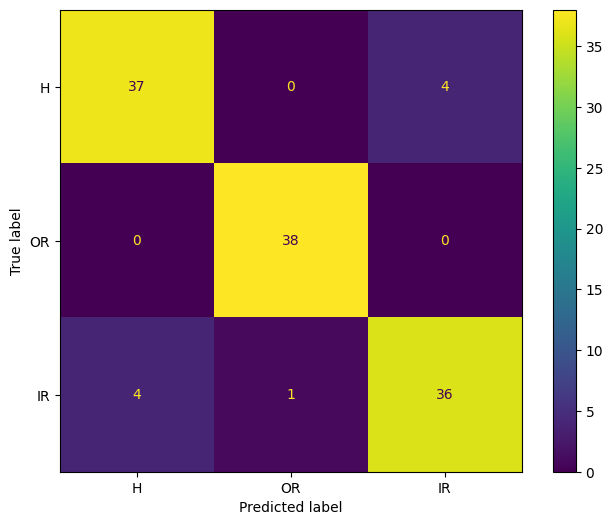

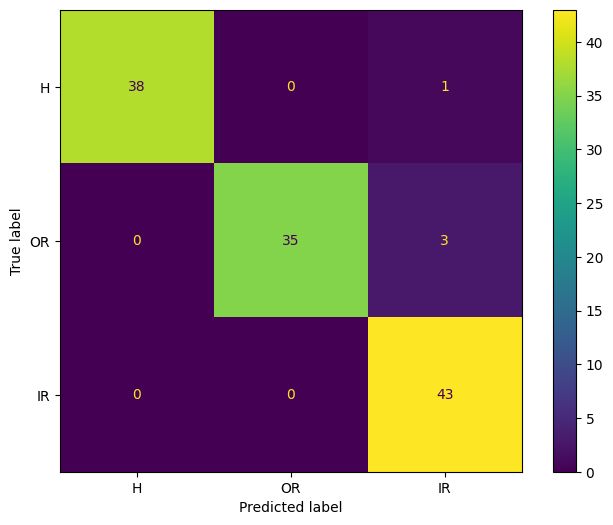

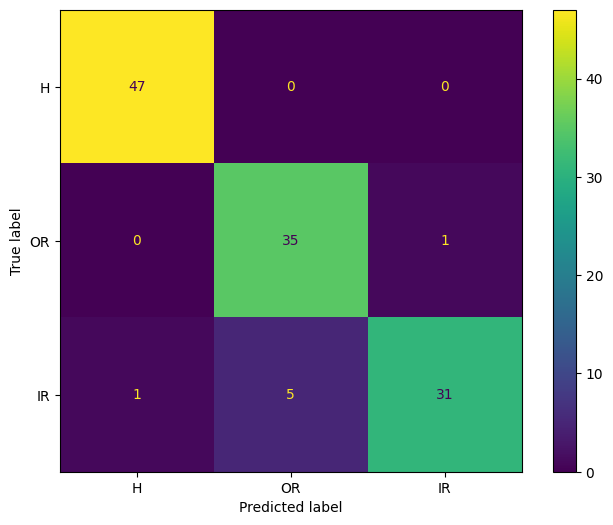

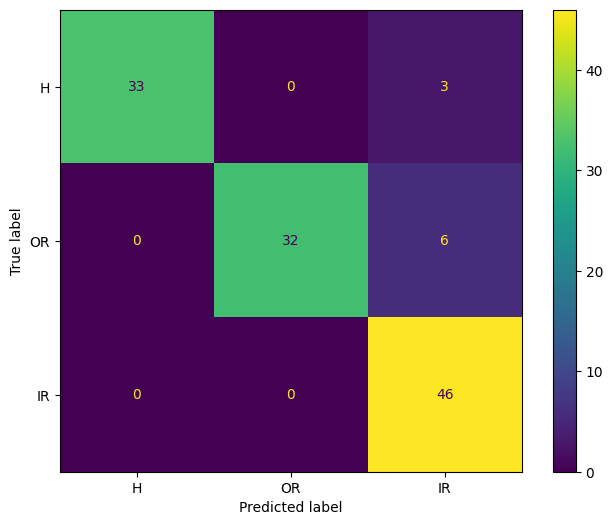

In [ ]:
# Validate and Visualize
perfEffNet = pd.DataFrame({'Metrics':['Val Acc.', 'Precision', 'F1_score', 'Recall']})
for fcase in ['tar3', 'tar4']:
    for tar in range(len(tarData)):
        root_path = root + fcase + '/'
        Model = torch.load('./saved_models/efficient_'+ fcase+ '_' + tarData[tar]+'.pth', map_location=device)
        _, TestLoader, _, numClass = loaddata(root_path, tarData[tar])
        val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader, numClass)
        print('Validation Accuracy = ', val_acc)
        print("__________________________________________________")
        print(f'Pricision Score = {prec}')
        print('__________________________________________________')
        print(f'F_1 Score =  {f1}')
        print('__________________________________________________')
        print(f"Recall Score =  {recall}")
        print('__________________________________________________')
        print('Response time per batch\n', time_batch)
        disp_conf_matrix(cm, class_names)

        perfEffNet = pd.concat((perfEffNet, pd.DataFrame({fcase+ '_' + str(tar) : [val_acc, prec, f1, recall]})), ignore_index = True, axis=1)

### ResNeXt

In [ ]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

for fcase in ['tar3', 'tar4']:
    for tar in range(len(tarData)):
          root_path = root + fcase + '/'
          TrainLoader, TestLoader, ValLoader, numClass = loaddata(root_path, tarData[tar])
          Model = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)
          Model.fc = ResNetFC(numClass)
          Model.to(device)
          optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
          criterion = nn.CrossEntropyLoss()
          print(f'Fine tuning ResNeXt model for traget data: {fcase}_{tarData[tar]}')
          Model = train(Model, TrainLoader, ValLoader, optC, criterion)
          torch.save(Model,'./saved_models/ResNeXt_'+ fcase+ '_' +tarData[tar]+'.pth')

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:01<00:00, 74.5MB/s]


Fine tuning ResNeXt model for traget data: tar3_tarData_1
Starting Training Loop...
[0/20]   Train Accuracy = 55.99    Val Accuracy = 67.71
[1/20]   Train Accuracy = 91.41    Val Accuracy = 84.38
[2/20]   Train Accuracy = 98.44    Val Accuracy = 91.67
[3/20]   Train Accuracy = 100.00    Val Accuracy = 93.75
[4/20]   Train Accuracy = 100.00    Val Accuracy = 93.75
[5/20]   Train Accuracy = 100.00    Val Accuracy = 92.71
[6/20]   Train Accuracy = 100.00    Val Accuracy = 93.75
[7/20]   Train Accuracy = 100.00    Val Accuracy = 93.75
[8/20]   Train Accuracy = 99.74    Val Accuracy = 93.75
[9/20]   Train Accuracy = 100.00    Val Accuracy = 91.67
[10/20]   Train Accuracy = 100.00    Val Accuracy = 93.75
[11/20]   Train Accuracy = 100.00    Val Accuracy = 94.79
[12/20]   Train Accuracy = 100.00    Val Accuracy = 94.79
[13/20]   Train Accuracy = 100.00    Val Accuracy = 93.75
[14/20]   Train Accuracy = 100.00    Val Accuracy = 93.75
[15/20]   Train Accuracy = 100.00    Val Accuracy = 95.83
[1

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning ResNeXt model for traget data: tar3_tarData_2
Starting Training Loop...
[0/20]   Train Accuracy = 60.00    Val Accuracy = 80.58
[1/20]   Train Accuracy = 95.44    Val Accuracy = 93.20
[2/20]   Train Accuracy = 98.48    Val Accuracy = 91.26
[3/20]   Train Accuracy = 100.00    Val Accuracy = 94.17
[4/20]   Train Accuracy = 99.75    Val Accuracy = 93.20
[5/20]   Train Accuracy = 100.00    Val Accuracy = 96.12
[6/20]   Train Accuracy = 99.75    Val Accuracy = 94.17
[7/20]   Train Accuracy = 100.00    Val Accuracy = 97.09
[8/20]   Train Accuracy = 100.00    Val Accuracy = 95.15
[9/20]   Train Accuracy = 100.00    Val Accuracy = 96.12
[10/20]   Train Accuracy = 100.00    Val Accuracy = 97.09
[11/20]   Train Accuracy = 100.00    Val Accuracy = 94.17
[12/20]   Train Accuracy = 100.00    Val Accuracy = 95.15
[13/20]   Train Accuracy = 100.00    Val Accuracy = 96.12
[14/20]   Train Accuracy = 100.00    Val Accuracy = 97.09
[15/20]   Train Accuracy = 100.00    Val Accuracy = 95.15
[16

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning ResNeXt model for traget data: tar3_tarData_3
Starting Training Loop...
[0/20]   Train Accuracy = 46.88    Val Accuracy = 82.29
[1/20]   Train Accuracy = 89.06    Val Accuracy = 87.50
[2/20]   Train Accuracy = 99.74    Val Accuracy = 95.83
[3/20]   Train Accuracy = 99.48    Val Accuracy = 96.88
[4/20]   Train Accuracy = 100.00    Val Accuracy = 97.92
[5/20]   Train Accuracy = 99.22    Val Accuracy = 95.83
[6/20]   Train Accuracy = 100.00    Val Accuracy = 94.79
[7/20]   Train Accuracy = 100.00    Val Accuracy = 95.83
[8/20]   Train Accuracy = 99.74    Val Accuracy = 93.75
[9/20]   Train Accuracy = 100.00    Val Accuracy = 94.79
[10/20]   Train Accuracy = 100.00    Val Accuracy = 96.88
[11/20]   Train Accuracy = 100.00    Val Accuracy = 97.92
[12/20]   Train Accuracy = 100.00    Val Accuracy = 97.92
[13/20]   Train Accuracy = 100.00    Val Accuracy = 96.88
[14/20]   Train Accuracy = 100.00    Val Accuracy = 95.83
[15/20]   Train Accuracy = 100.00    Val Accuracy = 94.79
[16/

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning ResNeXt model for traget data: tar3_tarData_4
Starting Training Loop...
[0/20]   Train Accuracy = 55.99    Val Accuracy = 78.12
[1/20]   Train Accuracy = 89.84    Val Accuracy = 94.79
[2/20]   Train Accuracy = 98.96    Val Accuracy = 87.50
[3/20]   Train Accuracy = 98.96    Val Accuracy = 93.75
[4/20]   Train Accuracy = 100.00    Val Accuracy = 89.58
[5/20]   Train Accuracy = 100.00    Val Accuracy = 94.79
[6/20]   Train Accuracy = 100.00    Val Accuracy = 96.88
[7/20]   Train Accuracy = 100.00    Val Accuracy = 96.88
[8/20]   Train Accuracy = 100.00    Val Accuracy = 96.88
[9/20]   Train Accuracy = 100.00    Val Accuracy = 94.79
[10/20]   Train Accuracy = 100.00    Val Accuracy = 96.88
[11/20]   Train Accuracy = 100.00    Val Accuracy = 98.96
[12/20]   Train Accuracy = 100.00    Val Accuracy = 96.88
[13/20]   Train Accuracy = 99.74    Val Accuracy = 96.88
[14/20]   Train Accuracy = 99.48    Val Accuracy = 97.92
[15/20]   Train Accuracy = 100.00    Val Accuracy = 100.00
[16

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning ResNeXt model for traget data: tar4_tarData_1
Starting Training Loop...
[0/20]   Train Accuracy = 62.24    Val Accuracy = 83.33
[1/20]   Train Accuracy = 95.57    Val Accuracy = 92.71
[2/20]   Train Accuracy = 99.48    Val Accuracy = 97.92
[3/20]   Train Accuracy = 100.00    Val Accuracy = 94.79
[4/20]   Train Accuracy = 100.00    Val Accuracy = 97.92
[5/20]   Train Accuracy = 100.00    Val Accuracy = 96.88
[6/20]   Train Accuracy = 100.00    Val Accuracy = 97.92
[7/20]   Train Accuracy = 99.74    Val Accuracy = 98.96
[8/20]   Train Accuracy = 100.00    Val Accuracy = 95.83
[9/20]   Train Accuracy = 100.00    Val Accuracy = 98.96
[10/20]   Train Accuracy = 100.00    Val Accuracy = 94.79
[11/20]   Train Accuracy = 100.00    Val Accuracy = 97.92
[12/20]   Train Accuracy = 100.00    Val Accuracy = 97.92
[13/20]   Train Accuracy = 100.00    Val Accuracy = 98.96
[14/20]   Train Accuracy = 100.00    Val Accuracy = 98.96
[15/20]   Train Accuracy = 100.00    Val Accuracy = 97.92
[1

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning ResNeXt model for traget data: tar4_tarData_2
Starting Training Loop...
[0/20]   Train Accuracy = 62.50    Val Accuracy = 88.54
[1/20]   Train Accuracy = 98.44    Val Accuracy = 98.96
[2/20]   Train Accuracy = 99.74    Val Accuracy = 98.96
[3/20]   Train Accuracy = 100.00    Val Accuracy = 97.92
[4/20]   Train Accuracy = 100.00    Val Accuracy = 100.00
[5/20]   Train Accuracy = 100.00    Val Accuracy = 100.00
[6/20]   Train Accuracy = 100.00    Val Accuracy = 91.67
[7/20]   Train Accuracy = 99.74    Val Accuracy = 98.96
[8/20]   Train Accuracy = 100.00    Val Accuracy = 100.00
[9/20]   Train Accuracy = 100.00    Val Accuracy = 100.00
[10/20]   Train Accuracy = 100.00    Val Accuracy = 100.00
[11/20]   Train Accuracy = 100.00    Val Accuracy = 100.00
[12/20]   Train Accuracy = 100.00    Val Accuracy = 100.00
[13/20]   Train Accuracy = 100.00    Val Accuracy = 100.00
[14/20]   Train Accuracy = 100.00    Val Accuracy = 100.00
[15/20]   Train Accuracy = 100.00    Val Accuracy =

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning ResNeXt model for traget data: tar4_tarData_3
Starting Training Loop...
[0/20]   Train Accuracy = 52.34    Val Accuracy = 80.21
[1/20]   Train Accuracy = 95.83    Val Accuracy = 87.50
[2/20]   Train Accuracy = 100.00    Val Accuracy = 88.54
[3/20]   Train Accuracy = 100.00    Val Accuracy = 90.62
[4/20]   Train Accuracy = 100.00    Val Accuracy = 90.62
[5/20]   Train Accuracy = 99.48    Val Accuracy = 96.88
[6/20]   Train Accuracy = 100.00    Val Accuracy = 92.71
[7/20]   Train Accuracy = 100.00    Val Accuracy = 89.58
[8/20]   Train Accuracy = 100.00    Val Accuracy = 95.83
[9/20]   Train Accuracy = 100.00    Val Accuracy = 90.62
[10/20]   Train Accuracy = 99.22    Val Accuracy = 94.79
[11/20]   Train Accuracy = 100.00    Val Accuracy = 96.88
[12/20]   Train Accuracy = 100.00    Val Accuracy = 92.71
[13/20]   Train Accuracy = 100.00    Val Accuracy = 91.67
[14/20]   Train Accuracy = 99.74    Val Accuracy = 97.92
[15/20]   Train Accuracy = 100.00    Val Accuracy = 96.88
[16

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning ResNeXt model for traget data: tar4_tarData_4
Starting Training Loop...
[0/20]   Train Accuracy = 55.73    Val Accuracy = 86.46
[1/20]   Train Accuracy = 98.44    Val Accuracy = 92.71
[2/20]   Train Accuracy = 99.74    Val Accuracy = 95.83
[3/20]   Train Accuracy = 99.74    Val Accuracy = 100.00
[4/20]   Train Accuracy = 100.00    Val Accuracy = 97.92
[5/20]   Train Accuracy = 100.00    Val Accuracy = 95.83
[6/20]   Train Accuracy = 100.00    Val Accuracy = 94.79
[7/20]   Train Accuracy = 100.00    Val Accuracy = 96.88
[8/20]   Train Accuracy = 99.48    Val Accuracy = 91.67
[9/20]   Train Accuracy = 100.00    Val Accuracy = 95.83
[10/20]   Train Accuracy = 100.00    Val Accuracy = 94.79
[11/20]   Train Accuracy = 100.00    Val Accuracy = 96.88
[12/20]   Train Accuracy = 100.00    Val Accuracy = 94.79
[13/20]   Train Accuracy = 100.00    Val Accuracy = 96.88
[14/20]   Train Accuracy = 100.00    Val Accuracy = 95.83
[15/20]   Train Accuracy = 100.00    Val Accuracy = 96.88
[1

Validation Accuracy =  98.33333333333333
__________________________________________________
Pricision Score = 0.985479797979798
__________________________________________________
F_1 Score =  0.985479797979798
__________________________________________________
Recall Score =  0.985479797979798
__________________________________________________
Response time per batch 0.04841423034667969
Validation Accuracy =  93.28358208955224
__________________________________________________
Pricision Score = 0.9370567375886525
__________________________________________________
F_1 Score =  0.9323060081680771
__________________________________________________
Recall Score =  0.9375
__________________________________________________
Response time per batch 0.04703807830810547
Validation Accuracy =  94.16666666666667
__________________________________________________
Pricision Score = 0.9433773509403761
__________________________________________________
F_1 Score =  0.9421285920613576
_________________

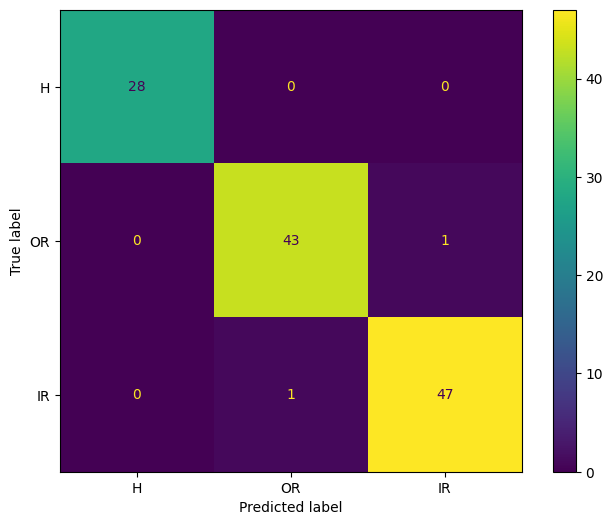

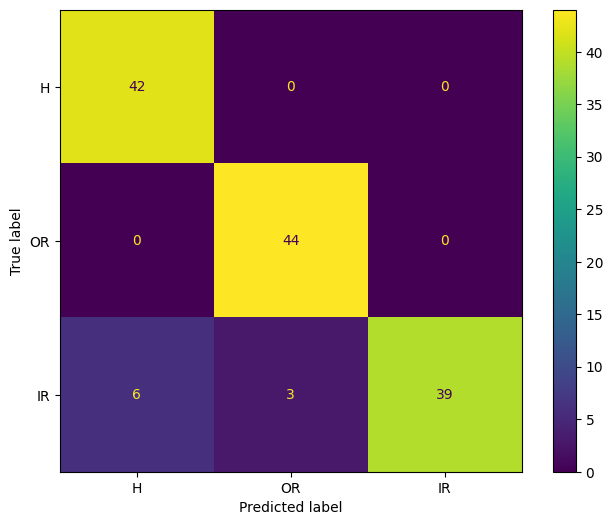

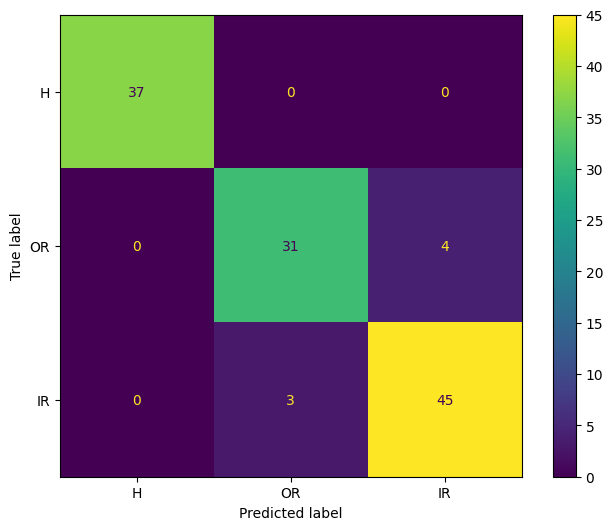

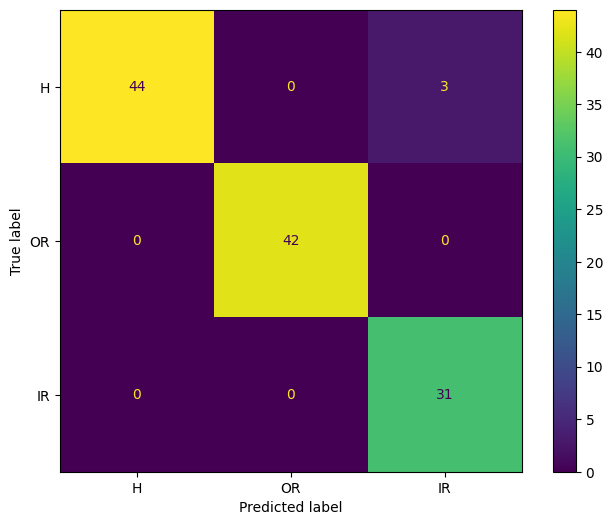

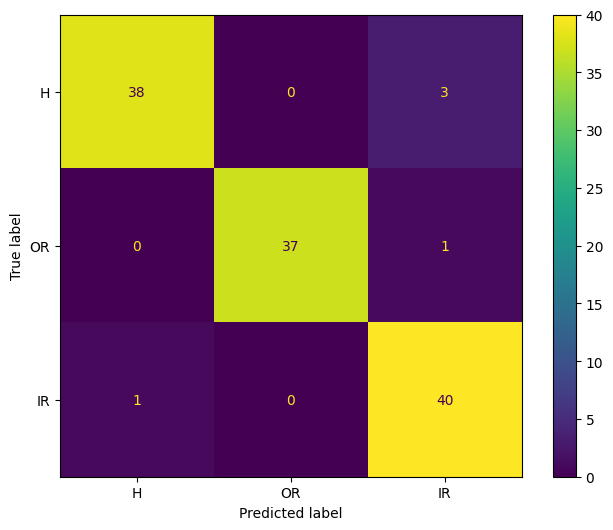

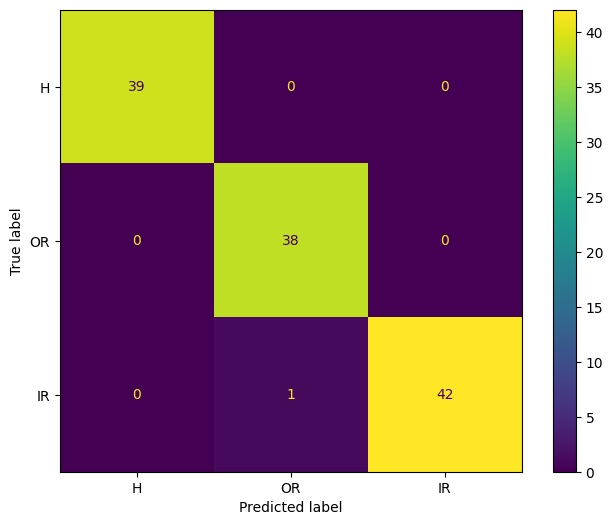

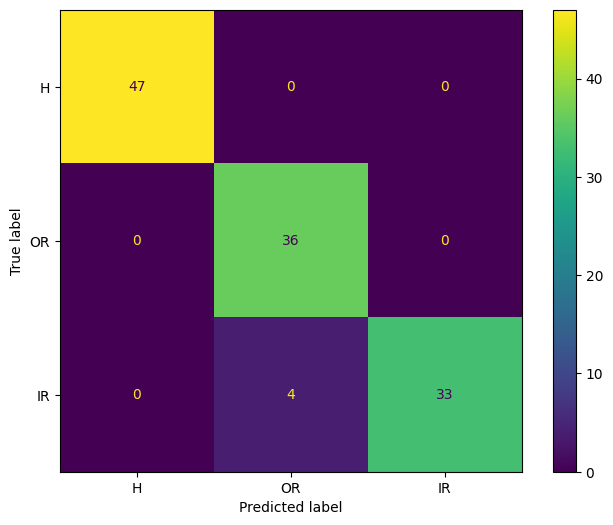

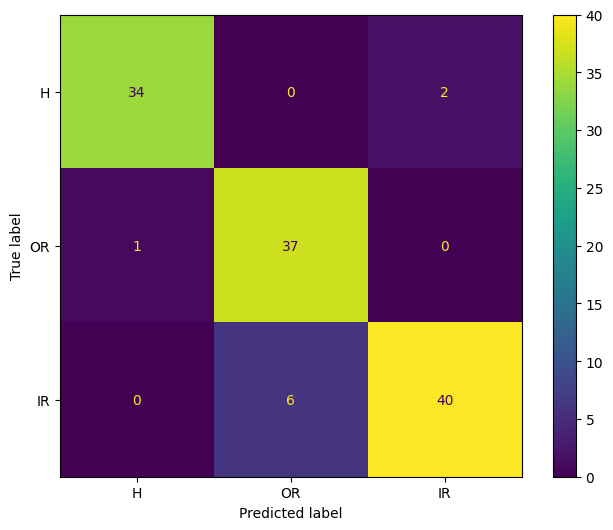

In [ ]:
# Validate and Visualize
perfResNeXt = pd.DataFrame({'Metrics':['Val Acc.', 'Precision', 'F1_score', 'Recall']})
for fcase in ['tar3', 'tar4']:
    for tar in range(len(tarData)):
        root_path = root + fcase + '/'
        _, TestLoader, _, numClass = loaddata(root_path, tarData[tar])
        Model = torch.load('./saved_models/ResNeXt_'+ fcase+ '_' +tarData[tar]+'.pth', map_location=device)
        val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader, numClass)
        print('Validation Accuracy = ', val_acc)
        print("__________________________________________________")
        print(f'Pricision Score = {prec}')
        print('__________________________________________________')
        print(f'F_1 Score =  {f1}')
        print('__________________________________________________')
        print(f"Recall Score =  {recall}")
        print('__________________________________________________')
        print('Response time per batch', time_batch)
        disp_conf_matrix(cm, class_names)
        perfResNeXt = pd.concat((perfResNeXt, pd.DataFrame({fcase+ '_' + str(tar) : [val_acc, prec, f1, recall]})), ignore_index = True, axis=1)

### DenseNet

In [ ]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

for fcase in ['tar3', 'tar4']:
  for tar in range(len(tarData)):
      root_path = root + fcase + '/'
      TrainLoader, TestLoader, ValLoader, numClass = loaddata(root_path, tarData[tar])
      Model = DenseNet(numClass)
      Model.to(device)
      optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
      criterion = nn.CrossEntropyLoss()
      print(f'Fine tuning DenseNet model for traget data: {fcase}_{tarData[tar]}')
      Model = train(Model, TrainLoader, ValLoader, optC, criterion)
      torch.save(Model,'./saved_models/DenseNet_'+ fcase+ '_'+tarData[tar]+'.pth')

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 64.7MB/s]


Fine tuning DenseNet model for traget data: tar3_tarData_1
Starting Training Loop...
[0/20]   Train Accuracy = 45.57    Val Accuracy = 56.25
[1/20]   Train Accuracy = 79.43    Val Accuracy = 70.83
[2/20]   Train Accuracy = 97.40    Val Accuracy = 82.29
[3/20]   Train Accuracy = 100.00    Val Accuracy = 82.29
[4/20]   Train Accuracy = 100.00    Val Accuracy = 81.25
[5/20]   Train Accuracy = 100.00    Val Accuracy = 82.29
[6/20]   Train Accuracy = 100.00    Val Accuracy = 85.42
[7/20]   Train Accuracy = 100.00    Val Accuracy = 83.33
[8/20]   Train Accuracy = 100.00    Val Accuracy = 82.29
[9/20]   Train Accuracy = 100.00    Val Accuracy = 83.33
[10/20]   Train Accuracy = 100.00    Val Accuracy = 82.29
[11/20]   Train Accuracy = 100.00    Val Accuracy = 81.25
[12/20]   Train Accuracy = 100.00    Val Accuracy = 83.33
[13/20]   Train Accuracy = 99.74    Val Accuracy = 84.38
[14/20]   Train Accuracy = 98.96    Val Accuracy = 82.29
[15/20]   Train Accuracy = 99.74    Val Accuracy = 80.21
[16

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning DenseNet model for traget data: tar3_tarData_2
Starting Training Loop...
[0/20]   Train Accuracy = 42.28    Val Accuracy = 60.19
[1/20]   Train Accuracy = 79.75    Val Accuracy = 73.79
[2/20]   Train Accuracy = 99.75    Val Accuracy = 79.61
[3/20]   Train Accuracy = 100.00    Val Accuracy = 83.50
[4/20]   Train Accuracy = 100.00    Val Accuracy = 83.50
[5/20]   Train Accuracy = 100.00    Val Accuracy = 87.38
[6/20]   Train Accuracy = 100.00    Val Accuracy = 85.44
[7/20]   Train Accuracy = 100.00    Val Accuracy = 85.44
[8/20]   Train Accuracy = 100.00    Val Accuracy = 82.52
[9/20]   Train Accuracy = 100.00    Val Accuracy = 79.61
[10/20]   Train Accuracy = 100.00    Val Accuracy = 87.38
[11/20]   Train Accuracy = 100.00    Val Accuracy = 77.67
[12/20]   Train Accuracy = 99.49    Val Accuracy = 86.41
[13/20]   Train Accuracy = 100.00    Val Accuracy = 86.41
[14/20]   Train Accuracy = 100.00    Val Accuracy = 89.32
[15/20]   Train Accuracy = 100.00    Val Accuracy = 87.38
[

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning DenseNet model for traget data: tar3_tarData_3
Starting Training Loop...
[0/20]   Train Accuracy = 40.10    Val Accuracy = 53.12
[1/20]   Train Accuracy = 67.45    Val Accuracy = 78.12
[2/20]   Train Accuracy = 98.70    Val Accuracy = 82.29
[3/20]   Train Accuracy = 100.00    Val Accuracy = 83.33
[4/20]   Train Accuracy = 100.00    Val Accuracy = 86.46
[5/20]   Train Accuracy = 100.00    Val Accuracy = 87.50
[6/20]   Train Accuracy = 100.00    Val Accuracy = 84.38
[7/20]   Train Accuracy = 100.00    Val Accuracy = 86.46
[8/20]   Train Accuracy = 100.00    Val Accuracy = 84.38
[9/20]   Train Accuracy = 100.00    Val Accuracy = 82.29
[10/20]   Train Accuracy = 100.00    Val Accuracy = 80.21
[11/20]   Train Accuracy = 100.00    Val Accuracy = 86.46
[12/20]   Train Accuracy = 100.00    Val Accuracy = 80.21
[13/20]   Train Accuracy = 99.74    Val Accuracy = 85.42
[14/20]   Train Accuracy = 97.92    Val Accuracy = 64.58
[15/20]   Train Accuracy = 99.48    Val Accuracy = 82.29
[16

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning DenseNet model for traget data: tar3_tarData_4
Starting Training Loop...
[0/20]   Train Accuracy = 37.24    Val Accuracy = 52.08
[1/20]   Train Accuracy = 73.70    Val Accuracy = 68.75
[2/20]   Train Accuracy = 95.31    Val Accuracy = 87.50
[3/20]   Train Accuracy = 100.00    Val Accuracy = 83.33
[4/20]   Train Accuracy = 100.00    Val Accuracy = 82.29
[5/20]   Train Accuracy = 100.00    Val Accuracy = 81.25
[6/20]   Train Accuracy = 100.00    Val Accuracy = 83.33
[7/20]   Train Accuracy = 100.00    Val Accuracy = 84.38
[8/20]   Train Accuracy = 100.00    Val Accuracy = 87.50
[9/20]   Train Accuracy = 100.00    Val Accuracy = 84.38
[10/20]   Train Accuracy = 100.00    Val Accuracy = 79.17
[11/20]   Train Accuracy = 99.48    Val Accuracy = 84.38
[12/20]   Train Accuracy = 100.00    Val Accuracy = 83.33
[13/20]   Train Accuracy = 100.00    Val Accuracy = 87.50
[14/20]   Train Accuracy = 99.74    Val Accuracy = 88.54
[15/20]   Train Accuracy = 100.00    Val Accuracy = 87.50
[1

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning DenseNet model for traget data: tar4_tarData_1
Starting Training Loop...
[0/20]   Train Accuracy = 32.81    Val Accuracy = 35.42
[1/20]   Train Accuracy = 66.15    Val Accuracy = 80.21
[2/20]   Train Accuracy = 99.48    Val Accuracy = 80.21
[3/20]   Train Accuracy = 100.00    Val Accuracy = 83.33
[4/20]   Train Accuracy = 100.00    Val Accuracy = 82.29
[5/20]   Train Accuracy = 100.00    Val Accuracy = 83.33
[6/20]   Train Accuracy = 100.00    Val Accuracy = 83.33
[7/20]   Train Accuracy = 100.00    Val Accuracy = 80.21
[8/20]   Train Accuracy = 100.00    Val Accuracy = 80.21
[9/20]   Train Accuracy = 100.00    Val Accuracy = 84.38
[10/20]   Train Accuracy = 99.22    Val Accuracy = 75.00
[11/20]   Train Accuracy = 100.00    Val Accuracy = 84.38
[12/20]   Train Accuracy = 99.74    Val Accuracy = 78.12
[13/20]   Train Accuracy = 99.74    Val Accuracy = 81.25
[14/20]   Train Accuracy = 99.74    Val Accuracy = 85.42
[15/20]   Train Accuracy = 100.00    Val Accuracy = 84.38
[16/

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning DenseNet model for traget data: tar4_tarData_2
Starting Training Loop...
[0/20]   Train Accuracy = 46.88    Val Accuracy = 55.21
[1/20]   Train Accuracy = 87.24    Val Accuracy = 75.00
[2/20]   Train Accuracy = 100.00    Val Accuracy = 89.58
[3/20]   Train Accuracy = 100.00    Val Accuracy = 87.50
[4/20]   Train Accuracy = 100.00    Val Accuracy = 88.54
[5/20]   Train Accuracy = 100.00    Val Accuracy = 88.54
[6/20]   Train Accuracy = 100.00    Val Accuracy = 86.46
[7/20]   Train Accuracy = 100.00    Val Accuracy = 89.58
[8/20]   Train Accuracy = 100.00    Val Accuracy = 92.71
[9/20]   Train Accuracy = 100.00    Val Accuracy = 89.58
[10/20]   Train Accuracy = 100.00    Val Accuracy = 88.54
[11/20]   Train Accuracy = 99.74    Val Accuracy = 87.50
[12/20]   Train Accuracy = 100.00    Val Accuracy = 89.58
[13/20]   Train Accuracy = 100.00    Val Accuracy = 86.46
[14/20]   Train Accuracy = 100.00    Val Accuracy = 90.62
[15/20]   Train Accuracy = 100.00    Val Accuracy = 89.58


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning DenseNet model for traget data: tar4_tarData_3
Starting Training Loop...
[0/20]   Train Accuracy = 35.42    Val Accuracy = 34.38
[1/20]   Train Accuracy = 66.15    Val Accuracy = 65.62
[2/20]   Train Accuracy = 99.48    Val Accuracy = 76.04
[3/20]   Train Accuracy = 100.00    Val Accuracy = 79.17
[4/20]   Train Accuracy = 100.00    Val Accuracy = 80.21
[5/20]   Train Accuracy = 100.00    Val Accuracy = 84.38
[6/20]   Train Accuracy = 100.00    Val Accuracy = 79.17
[7/20]   Train Accuracy = 100.00    Val Accuracy = 77.08
[8/20]   Train Accuracy = 100.00    Val Accuracy = 80.21
[9/20]   Train Accuracy = 100.00    Val Accuracy = 77.08
[10/20]   Train Accuracy = 100.00    Val Accuracy = 80.21
[11/20]   Train Accuracy = 100.00    Val Accuracy = 79.17
[12/20]   Train Accuracy = 100.00    Val Accuracy = 78.12
[13/20]   Train Accuracy = 100.00    Val Accuracy = 73.96
[14/20]   Train Accuracy = 100.00    Val Accuracy = 79.17
[15/20]   Train Accuracy = 100.00    Val Accuracy = 79.17


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning DenseNet model for traget data: tar4_tarData_4
Starting Training Loop...
[0/20]   Train Accuracy = 38.02    Val Accuracy = 51.04
[1/20]   Train Accuracy = 76.56    Val Accuracy = 81.25
[2/20]   Train Accuracy = 99.74    Val Accuracy = 89.58
[3/20]   Train Accuracy = 100.00    Val Accuracy = 87.50
[4/20]   Train Accuracy = 100.00    Val Accuracy = 88.54
[5/20]   Train Accuracy = 100.00    Val Accuracy = 86.46
[6/20]   Train Accuracy = 100.00    Val Accuracy = 88.54
[7/20]   Train Accuracy = 100.00    Val Accuracy = 89.58
[8/20]   Train Accuracy = 100.00    Val Accuracy = 85.42
[9/20]   Train Accuracy = 100.00    Val Accuracy = 86.46
[10/20]   Train Accuracy = 100.00    Val Accuracy = 89.58
[11/20]   Train Accuracy = 100.00    Val Accuracy = 90.62
[12/20]   Train Accuracy = 100.00    Val Accuracy = 89.58
[13/20]   Train Accuracy = 100.00    Val Accuracy = 88.54
[14/20]   Train Accuracy = 100.00    Val Accuracy = 87.50
[15/20]   Train Accuracy = 100.00    Val Accuracy = 81.25


Validation Accuracy =  80.83333333333333
__________________________________________________
Pricision Score = 0.835034013605442
__________________________________________________
F_1 Score =  0.8315682599187754
__________________________________________________
Recall Score =  0.8283730158730159
__________________________________________________
Response time per batch 0.12706661224365234


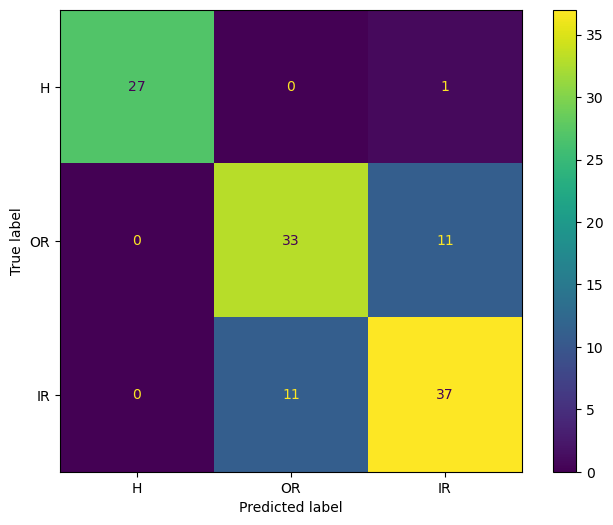

In [ ]:
# Validate and Visualize
tar = 0
fcase = 'tar3'
root_path = root + fcase + '/'
_, TestLoader, _,numClass = loaddata(root_path, tarData[0])
Model = torch.load('./saved_models/DenseNet_' + fcase+ '_' +tarData[0]+'.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader, numClass)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm, class_names)

perfDenseNet = {'Modelname':['DenseNet_'+fcase+'_'+tarData[tar]], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

### vgg16Net

In [ ]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

for fcase in ['tar3', 'tar4']:
  for tar in range(len(tarData)):
      root_path = root + fcase + '/'
      TrainLoader, TestLoader, ValLoader, numClass = loaddata(root_path, tarData[tar])
      Model = vgg16Net(numClass)
      Model.to(device)
      optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
      criterion = nn.CrossEntropyLoss()
      print(f'Fine tuning vgg16Net model for traget data: {fcase}_{tarData[tar]}')
      Model = train(Model, TrainLoader, ValLoader, optC, criterion)
      torch.save(Model,'./saved_models/vgg16Net_' + fcase+ '_' +tarData[tar]+'.pth')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 150MB/s]


Fine tuning vgg16Net model for traget data: tar3_tarData_1
Starting Training Loop...
[0/20]   Train Accuracy = 53.91    Val Accuracy = 58.33
[1/20]   Train Accuracy = 66.15    Val Accuracy = 63.54
[2/20]   Train Accuracy = 67.71    Val Accuracy = 67.71
[3/20]   Train Accuracy = 68.23    Val Accuracy = 65.62
[4/20]   Train Accuracy = 72.40    Val Accuracy = 70.83
[5/20]   Train Accuracy = 85.94    Val Accuracy = 80.21
[6/20]   Train Accuracy = 92.19    Val Accuracy = 83.33
[7/20]   Train Accuracy = 93.75    Val Accuracy = 86.46
[8/20]   Train Accuracy = 98.18    Val Accuracy = 84.38
[9/20]   Train Accuracy = 98.44    Val Accuracy = 83.33
[10/20]   Train Accuracy = 100.00    Val Accuracy = 87.50
[11/20]   Train Accuracy = 100.00    Val Accuracy = 84.38
[12/20]   Train Accuracy = 99.48    Val Accuracy = 78.12
[13/20]   Train Accuracy = 94.53    Val Accuracy = 82.29
[14/20]   Train Accuracy = 98.96    Val Accuracy = 84.38
[15/20]   Train Accuracy = 100.00    Val Accuracy = 87.50
[16/20]   

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning vgg16Net model for traget data: tar3_tarData_2
Starting Training Loop...
[0/20]   Train Accuracy = 49.11    Val Accuracy = 52.43
[1/20]   Train Accuracy = 59.24    Val Accuracy = 62.14
[2/20]   Train Accuracy = 79.75    Val Accuracy = 77.67
[3/20]   Train Accuracy = 82.53    Val Accuracy = 81.55
[4/20]   Train Accuracy = 89.87    Val Accuracy = 87.38
[5/20]   Train Accuracy = 94.43    Val Accuracy = 86.41
[6/20]   Train Accuracy = 96.71    Val Accuracy = 88.35
[7/20]   Train Accuracy = 98.23    Val Accuracy = 93.20
[8/20]   Train Accuracy = 100.00    Val Accuracy = 93.20
[9/20]   Train Accuracy = 100.00    Val Accuracy = 91.26
[10/20]   Train Accuracy = 90.89    Val Accuracy = 72.82
[11/20]   Train Accuracy = 89.87    Val Accuracy = 90.29
[12/20]   Train Accuracy = 93.67    Val Accuracy = 95.15
[13/20]   Train Accuracy = 99.75    Val Accuracy = 88.35
[14/20]   Train Accuracy = 100.00    Val Accuracy = 89.32
[15/20]   Train Accuracy = 100.00    Val Accuracy = 91.26
[16/20]  

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning vgg16Net model for traget data: tar3_tarData_3
Starting Training Loop...
[0/20]   Train Accuracy = 44.53    Val Accuracy = 43.75
[1/20]   Train Accuracy = 54.69    Val Accuracy = 52.08
[2/20]   Train Accuracy = 60.16    Val Accuracy = 42.71
[3/20]   Train Accuracy = 72.66    Val Accuracy = 77.08
[4/20]   Train Accuracy = 78.39    Val Accuracy = 84.38
[5/20]   Train Accuracy = 83.07    Val Accuracy = 62.50
[6/20]   Train Accuracy = 86.72    Val Accuracy = 84.38
[7/20]   Train Accuracy = 89.32    Val Accuracy = 82.29
[8/20]   Train Accuracy = 92.71    Val Accuracy = 72.92
[9/20]   Train Accuracy = 93.49    Val Accuracy = 75.00
[10/20]   Train Accuracy = 98.44    Val Accuracy = 88.54
[11/20]   Train Accuracy = 99.22    Val Accuracy = 80.21
[12/20]   Train Accuracy = 96.61    Val Accuracy = 84.38
[13/20]   Train Accuracy = 99.22    Val Accuracy = 86.46
[14/20]   Train Accuracy = 100.00    Val Accuracy = 93.75
[15/20]   Train Accuracy = 100.00    Val Accuracy = 83.33
[16/20]   T

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning vgg16Net model for traget data: tar3_tarData_4
Starting Training Loop...
[0/20]   Train Accuracy = 40.36    Val Accuracy = 42.71
[1/20]   Train Accuracy = 52.86    Val Accuracy = 44.79
[2/20]   Train Accuracy = 65.89    Val Accuracy = 68.75
[3/20]   Train Accuracy = 85.94    Val Accuracy = 79.17
[4/20]   Train Accuracy = 89.06    Val Accuracy = 85.42
[5/20]   Train Accuracy = 97.40    Val Accuracy = 87.50
[6/20]   Train Accuracy = 98.96    Val Accuracy = 87.50
[7/20]   Train Accuracy = 95.05    Val Accuracy = 87.50
[8/20]   Train Accuracy = 100.00    Val Accuracy = 85.42
[9/20]   Train Accuracy = 99.22    Val Accuracy = 86.46
[10/20]   Train Accuracy = 99.74    Val Accuracy = 85.42
[11/20]   Train Accuracy = 100.00    Val Accuracy = 89.58
[12/20]   Train Accuracy = 100.00    Val Accuracy = 86.46
[13/20]   Train Accuracy = 100.00    Val Accuracy = 88.54
[14/20]   Train Accuracy = 100.00    Val Accuracy = 89.58
[15/20]   Train Accuracy = 100.00    Val Accuracy = 89.58
[16/20]

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning vgg16Net model for traget data: tar4_tarData_1
Starting Training Loop...
[0/20]   Train Accuracy = 41.93    Val Accuracy = 47.92
[1/20]   Train Accuracy = 68.23    Val Accuracy = 42.71
[2/20]   Train Accuracy = 78.12    Val Accuracy = 70.83
[3/20]   Train Accuracy = 73.18    Val Accuracy = 71.88
[4/20]   Train Accuracy = 79.69    Val Accuracy = 80.21
[5/20]   Train Accuracy = 85.68    Val Accuracy = 72.92
[6/20]   Train Accuracy = 90.62    Val Accuracy = 75.00
[7/20]   Train Accuracy = 87.24    Val Accuracy = 78.12
[8/20]   Train Accuracy = 97.14    Val Accuracy = 82.29
[9/20]   Train Accuracy = 90.10    Val Accuracy = 63.54
[10/20]   Train Accuracy = 84.64    Val Accuracy = 71.88
[11/20]   Train Accuracy = 96.09    Val Accuracy = 81.25
[12/20]   Train Accuracy = 99.48    Val Accuracy = 86.46
[13/20]   Train Accuracy = 99.74    Val Accuracy = 84.38
[14/20]   Train Accuracy = 100.00    Val Accuracy = 84.38
[15/20]   Train Accuracy = 99.74    Val Accuracy = 79.17
[16/20]   Tr

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning vgg16Net model for traget data: tar4_tarData_2
Starting Training Loop...
[0/20]   Train Accuracy = 42.97    Val Accuracy = 32.29
[1/20]   Train Accuracy = 67.45    Val Accuracy = 75.00
[2/20]   Train Accuracy = 86.98    Val Accuracy = 80.21
[3/20]   Train Accuracy = 89.06    Val Accuracy = 83.33
[4/20]   Train Accuracy = 96.61    Val Accuracy = 84.38
[5/20]   Train Accuracy = 95.31    Val Accuracy = 86.46
[6/20]   Train Accuracy = 98.96    Val Accuracy = 90.62
[7/20]   Train Accuracy = 99.74    Val Accuracy = 91.67
[8/20]   Train Accuracy = 99.48    Val Accuracy = 89.58
[9/20]   Train Accuracy = 100.00    Val Accuracy = 89.58
[10/20]   Train Accuracy = 99.48    Val Accuracy = 85.42
[11/20]   Train Accuracy = 98.96    Val Accuracy = 90.62
[12/20]   Train Accuracy = 100.00    Val Accuracy = 90.62
[13/20]   Train Accuracy = 100.00    Val Accuracy = 90.62
[14/20]   Train Accuracy = 100.00    Val Accuracy = 91.67
[15/20]   Train Accuracy = 100.00    Val Accuracy = 91.67
[16/20] 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning vgg16Net model for traget data: tar4_tarData_3
Starting Training Loop...
[0/20]   Train Accuracy = 53.65    Val Accuracy = 37.50
[1/20]   Train Accuracy = 65.62    Val Accuracy = 63.54
[2/20]   Train Accuracy = 78.39    Val Accuracy = 83.33
[3/20]   Train Accuracy = 89.84    Val Accuracy = 76.04
[4/20]   Train Accuracy = 97.14    Val Accuracy = 85.42
[5/20]   Train Accuracy = 88.02    Val Accuracy = 79.17
[6/20]   Train Accuracy = 94.53    Val Accuracy = 87.50
[7/20]   Train Accuracy = 90.89    Val Accuracy = 83.33
[8/20]   Train Accuracy = 97.92    Val Accuracy = 84.38
[9/20]   Train Accuracy = 98.18    Val Accuracy = 83.33
[10/20]   Train Accuracy = 99.22    Val Accuracy = 92.71
[11/20]   Train Accuracy = 96.88    Val Accuracy = 85.42
[12/20]   Train Accuracy = 96.35    Val Accuracy = 60.42
[13/20]   Train Accuracy = 93.49    Val Accuracy = 83.33
[14/20]   Train Accuracy = 99.74    Val Accuracy = 87.50
[15/20]   Train Accuracy = 100.00    Val Accuracy = 89.58
[16/20]   Tr

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning vgg16Net model for traget data: tar4_tarData_4
Starting Training Loop...
[0/20]   Train Accuracy = 46.61    Val Accuracy = 47.92
[1/20]   Train Accuracy = 67.97    Val Accuracy = 88.54
[2/20]   Train Accuracy = 82.29    Val Accuracy = 89.58
[3/20]   Train Accuracy = 85.42    Val Accuracy = 91.67
[4/20]   Train Accuracy = 89.84    Val Accuracy = 81.25
[5/20]   Train Accuracy = 89.58    Val Accuracy = 89.58
[6/20]   Train Accuracy = 93.75    Val Accuracy = 93.75
[7/20]   Train Accuracy = 98.44    Val Accuracy = 92.71
[8/20]   Train Accuracy = 95.57    Val Accuracy = 83.33
[9/20]   Train Accuracy = 95.31    Val Accuracy = 93.75
[10/20]   Train Accuracy = 99.74    Val Accuracy = 91.67
[11/20]   Train Accuracy = 100.00    Val Accuracy = 94.79
[12/20]   Train Accuracy = 100.00    Val Accuracy = 90.62
[13/20]   Train Accuracy = 100.00    Val Accuracy = 93.75
[14/20]   Train Accuracy = 100.00    Val Accuracy = 95.83
[15/20]   Train Accuracy = 100.00    Val Accuracy = 93.75
[16/20] 

Validation Accuracy =  85.83333333333333
__________________________________________________
Pricision Score = 0.87804502004317
__________________________________________________
F_1 Score =  0.8750310118731172
__________________________________________________
Recall Score =  0.872564935064935
__________________________________________________
Response time per batch 0.2075510025024414


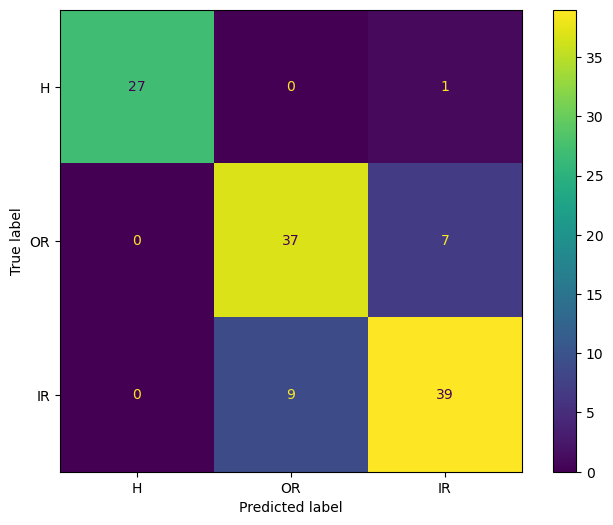

In [ ]:
# Validate and Visualize
tar = 0
fcase = 'tar3'
root_path = root + fcase + '/'
_, TestLoader, _,numClass = loaddata(root_path, tarData[0])
Model = torch.load('./saved_models/vgg16Net_' + fcase+ '_' +tarData[0]+'.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader, numClass)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm, class_names)

perfvgg16Net = {'Modelname':['vgg16Net_'+fcase+'_'+tarData[tar]], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

### GoogleNet

In [ ]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

for fcase in ['tar3', 'tar4']:
  for tar in range(len(tarData)):
      root_path = root + fcase + '/'
      TrainLoader, TestLoader, ValLoader, numClass = loaddata(root_path, tarData[tar])
      Model = googleNet(numClass)
      Model.to(device)
      optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
      criterion = nn.CrossEntropyLoss()
      print(f'Fine tuning GoogleNet model for traget data: {fcase}_{tarData[tar]}')
      Model = train(Model, TrainLoader, ValLoader, optC, criterion)
      torch.save(Model,'./saved_models/GoogleNet_' + fcase+ '_' +tarData[tar]+'.pth')

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 61.6MB/s]


Fine tuning GoogleNet model for traget data: tar3_tarData_1
Starting Training Loop...
[0/20]   Train Accuracy = 59.38    Val Accuracy = 61.46
[1/20]   Train Accuracy = 82.29    Val Accuracy = 71.88
[2/20]   Train Accuracy = 99.48    Val Accuracy = 76.04
[3/20]   Train Accuracy = 100.00    Val Accuracy = 76.04
[4/20]   Train Accuracy = 100.00    Val Accuracy = 77.08
[5/20]   Train Accuracy = 100.00    Val Accuracy = 76.04
[6/20]   Train Accuracy = 99.74    Val Accuracy = 76.04
[7/20]   Train Accuracy = 100.00    Val Accuracy = 73.96
[8/20]   Train Accuracy = 100.00    Val Accuracy = 75.00
[9/20]   Train Accuracy = 100.00    Val Accuracy = 77.08
[10/20]   Train Accuracy = 100.00    Val Accuracy = 78.12
[11/20]   Train Accuracy = 100.00    Val Accuracy = 78.12
[12/20]   Train Accuracy = 100.00    Val Accuracy = 75.00
[13/20]   Train Accuracy = 100.00    Val Accuracy = 81.25
[14/20]   Train Accuracy = 100.00    Val Accuracy = 78.12
[15/20]   Train Accuracy = 100.00    Val Accuracy = 79.17


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning GoogleNet model for traget data: tar3_tarData_2
Starting Training Loop...
[0/20]   Train Accuracy = 37.47    Val Accuracy = 44.66
[1/20]   Train Accuracy = 83.29    Val Accuracy = 74.76
[2/20]   Train Accuracy = 99.24    Val Accuracy = 79.61
[3/20]   Train Accuracy = 100.00    Val Accuracy = 79.61
[4/20]   Train Accuracy = 100.00    Val Accuracy = 81.55
[5/20]   Train Accuracy = 100.00    Val Accuracy = 81.55
[6/20]   Train Accuracy = 100.00    Val Accuracy = 81.55
[7/20]   Train Accuracy = 100.00    Val Accuracy = 81.55
[8/20]   Train Accuracy = 100.00    Val Accuracy = 80.58
[9/20]   Train Accuracy = 100.00    Val Accuracy = 81.55
[10/20]   Train Accuracy = 100.00    Val Accuracy = 79.61
[11/20]   Train Accuracy = 100.00    Val Accuracy = 82.52
[12/20]   Train Accuracy = 99.49    Val Accuracy = 84.47
[13/20]   Train Accuracy = 100.00    Val Accuracy = 83.50
[14/20]   Train Accuracy = 100.00    Val Accuracy = 82.52
[15/20]   Train Accuracy = 100.00    Val Accuracy = 84.47


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning GoogleNet model for traget data: tar3_tarData_3
Starting Training Loop...
[0/20]   Train Accuracy = 45.57    Val Accuracy = 60.42
[1/20]   Train Accuracy = 74.48    Val Accuracy = 65.62
[2/20]   Train Accuracy = 97.40    Val Accuracy = 78.12
[3/20]   Train Accuracy = 100.00    Val Accuracy = 77.08
[4/20]   Train Accuracy = 100.00    Val Accuracy = 85.42
[5/20]   Train Accuracy = 100.00    Val Accuracy = 78.12
[6/20]   Train Accuracy = 100.00    Val Accuracy = 79.17
[7/20]   Train Accuracy = 100.00    Val Accuracy = 84.38
[8/20]   Train Accuracy = 100.00    Val Accuracy = 84.38
[9/20]   Train Accuracy = 100.00    Val Accuracy = 84.38
[10/20]   Train Accuracy = 100.00    Val Accuracy = 84.38
[11/20]   Train Accuracy = 100.00    Val Accuracy = 80.21
[12/20]   Train Accuracy = 99.48    Val Accuracy = 80.21
[13/20]   Train Accuracy = 100.00    Val Accuracy = 83.33
[14/20]   Train Accuracy = 100.00    Val Accuracy = 83.33
[15/20]   Train Accuracy = 100.00    Val Accuracy = 75.00


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning GoogleNet model for traget data: tar3_tarData_4
Starting Training Loop...
[0/20]   Train Accuracy = 39.32    Val Accuracy = 54.17
[1/20]   Train Accuracy = 83.07    Val Accuracy = 73.96
[2/20]   Train Accuracy = 98.18    Val Accuracy = 76.04
[3/20]   Train Accuracy = 100.00    Val Accuracy = 78.12
[4/20]   Train Accuracy = 100.00    Val Accuracy = 79.17
[5/20]   Train Accuracy = 100.00    Val Accuracy = 82.29
[6/20]   Train Accuracy = 100.00    Val Accuracy = 81.25
[7/20]   Train Accuracy = 100.00    Val Accuracy = 75.00
[8/20]   Train Accuracy = 100.00    Val Accuracy = 78.12
[9/20]   Train Accuracy = 100.00    Val Accuracy = 71.88
[10/20]   Train Accuracy = 100.00    Val Accuracy = 80.21
[11/20]   Train Accuracy = 100.00    Val Accuracy = 83.33
[12/20]   Train Accuracy = 100.00    Val Accuracy = 83.33
[13/20]   Train Accuracy = 100.00    Val Accuracy = 79.17
[14/20]   Train Accuracy = 100.00    Val Accuracy = 81.25
[15/20]   Train Accuracy = 100.00    Val Accuracy = 86.46

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning GoogleNet model for traget data: tar4_tarData_1
Starting Training Loop...
[0/20]   Train Accuracy = 39.06    Val Accuracy = 57.29
[1/20]   Train Accuracy = 80.73    Val Accuracy = 69.79
[2/20]   Train Accuracy = 98.70    Val Accuracy = 73.96
[3/20]   Train Accuracy = 100.00    Val Accuracy = 72.92
[4/20]   Train Accuracy = 100.00    Val Accuracy = 75.00
[5/20]   Train Accuracy = 100.00    Val Accuracy = 71.88
[6/20]   Train Accuracy = 100.00    Val Accuracy = 71.88
[7/20]   Train Accuracy = 100.00    Val Accuracy = 71.88
[8/20]   Train Accuracy = 100.00    Val Accuracy = 73.96
[9/20]   Train Accuracy = 100.00    Val Accuracy = 77.08
[10/20]   Train Accuracy = 100.00    Val Accuracy = 70.83
[11/20]   Train Accuracy = 100.00    Val Accuracy = 75.00
[12/20]   Train Accuracy = 100.00    Val Accuracy = 72.92
[13/20]   Train Accuracy = 100.00    Val Accuracy = 71.88
[14/20]   Train Accuracy = 100.00    Val Accuracy = 72.92
[15/20]   Train Accuracy = 100.00    Val Accuracy = 72.92

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning GoogleNet model for traget data: tar4_tarData_2
Starting Training Loop...
[0/20]   Train Accuracy = 42.19    Val Accuracy = 72.92
[1/20]   Train Accuracy = 87.50    Val Accuracy = 78.12
[2/20]   Train Accuracy = 99.48    Val Accuracy = 86.46
[3/20]   Train Accuracy = 100.00    Val Accuracy = 82.29
[4/20]   Train Accuracy = 100.00    Val Accuracy = 84.38
[5/20]   Train Accuracy = 100.00    Val Accuracy = 89.58
[6/20]   Train Accuracy = 100.00    Val Accuracy = 85.42
[7/20]   Train Accuracy = 100.00    Val Accuracy = 88.54
[8/20]   Train Accuracy = 100.00    Val Accuracy = 87.50
[9/20]   Train Accuracy = 100.00    Val Accuracy = 84.38
[10/20]   Train Accuracy = 100.00    Val Accuracy = 90.62
[11/20]   Train Accuracy = 100.00    Val Accuracy = 82.29
[12/20]   Train Accuracy = 100.00    Val Accuracy = 87.50
[13/20]   Train Accuracy = 100.00    Val Accuracy = 86.46
[14/20]   Train Accuracy = 100.00    Val Accuracy = 88.54
[15/20]   Train Accuracy = 99.74    Val Accuracy = 84.38


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning GoogleNet model for traget data: tar4_tarData_3
Starting Training Loop...
[0/20]   Train Accuracy = 37.50    Val Accuracy = 48.96
[1/20]   Train Accuracy = 81.51    Val Accuracy = 64.58
[2/20]   Train Accuracy = 98.44    Val Accuracy = 75.00
[3/20]   Train Accuracy = 99.74    Val Accuracy = 72.92
[4/20]   Train Accuracy = 100.00    Val Accuracy = 72.92
[5/20]   Train Accuracy = 100.00    Val Accuracy = 75.00
[6/20]   Train Accuracy = 100.00    Val Accuracy = 71.88
[7/20]   Train Accuracy = 100.00    Val Accuracy = 71.88
[8/20]   Train Accuracy = 100.00    Val Accuracy = 69.79
[9/20]   Train Accuracy = 100.00    Val Accuracy = 78.12
[10/20]   Train Accuracy = 100.00    Val Accuracy = 73.96
[11/20]   Train Accuracy = 100.00    Val Accuracy = 72.92
[12/20]   Train Accuracy = 100.00    Val Accuracy = 76.04
[13/20]   Train Accuracy = 99.48    Val Accuracy = 75.00
[14/20]   Train Accuracy = 99.74    Val Accuracy = 71.88
[15/20]   Train Accuracy = 100.00    Val Accuracy = 75.00
[1

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning GoogleNet model for traget data: tar4_tarData_4
Starting Training Loop...
[0/20]   Train Accuracy = 40.89    Val Accuracy = 54.17
[1/20]   Train Accuracy = 85.94    Val Accuracy = 69.79
[2/20]   Train Accuracy = 99.22    Val Accuracy = 71.88
[3/20]   Train Accuracy = 100.00    Val Accuracy = 78.12
[4/20]   Train Accuracy = 100.00    Val Accuracy = 82.29
[5/20]   Train Accuracy = 100.00    Val Accuracy = 76.04
[6/20]   Train Accuracy = 100.00    Val Accuracy = 75.00
[7/20]   Train Accuracy = 100.00    Val Accuracy = 78.12
[8/20]   Train Accuracy = 100.00    Val Accuracy = 79.17
[9/20]   Train Accuracy = 100.00    Val Accuracy = 77.08
[10/20]   Train Accuracy = 100.00    Val Accuracy = 87.50
[11/20]   Train Accuracy = 100.00    Val Accuracy = 82.29
[12/20]   Train Accuracy = 99.48    Val Accuracy = 86.46
[13/20]   Train Accuracy = 99.48    Val Accuracy = 77.08
[14/20]   Train Accuracy = 100.00    Val Accuracy = 87.50
[15/20]   Train Accuracy = 100.00    Val Accuracy = 84.38
[

Validation Accuracy =  78.33333333333333
__________________________________________________
Pricision Score = 0.8105311355311354
__________________________________________________
F_1 Score =  0.8062770562770564
__________________________________________________
Recall Score =  0.8094336219336219
__________________________________________________
Response time per batch 0.07242202758789062


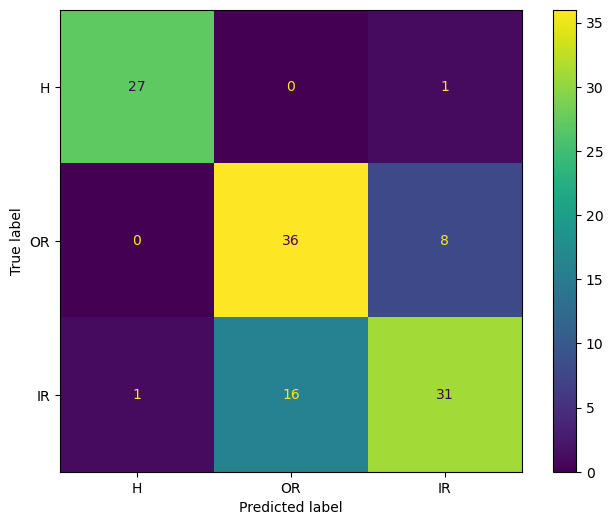

In [ ]:
# Validate and Visualize
tar = 0
fcase = 'tar3'
root_path = root + fcase + '/'
_, TestLoader, _,numClass = loaddata(root_path, tarData[0])
Model = torch.load('./saved_models/GoogleNet_' + fcase+ '_' +tarData[0]+'.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader, numClass)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm, class_names)

perfgoogleNet = {'Modelname':['GoogleNet_'+fcase+'_'+tarData[tar]], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

### SqeezeNet

In [ ]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

for fcase in ['tar3', 'tar4']:
      for tar in range(len(tarData)):
          root_path = root + fcase + '/'
          TrainLoader, _, ValLoader, numClass = loaddata(root_path, tarData[tar])
          Model = SqeezeNet(numClass)
          Model.to(device)
          optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
          criterion = nn.CrossEntropyLoss()
          print(f'Fine tuning SqeezeNet model for traget data: {fcase}_{tarData[tar]}')
          Model = train(Model, TrainLoader, ValLoader, optC, criterion)
          torch.save(Model,'./saved_models/SqeezeNet_' + fcase+ '_' +tarData[tar]+'.pth')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:00<00:00, 26.2MB/s]


Fine tuning SqeezeNet model for traget data: tar3_tarData_1
Starting Training Loop...
[0/20]   Train Accuracy = 24.22    Val Accuracy = 32.29
[1/20]   Train Accuracy = 48.70    Val Accuracy = 44.79
[2/20]   Train Accuracy = 62.50    Val Accuracy = 60.42
[3/20]   Train Accuracy = 60.42    Val Accuracy = 64.58
[4/20]   Train Accuracy = 67.71    Val Accuracy = 70.83
[5/20]   Train Accuracy = 74.74    Val Accuracy = 66.67
[6/20]   Train Accuracy = 75.26    Val Accuracy = 67.71
[7/20]   Train Accuracy = 75.00    Val Accuracy = 65.62
[8/20]   Train Accuracy = 80.47    Val Accuracy = 71.88
[9/20]   Train Accuracy = 81.51    Val Accuracy = 76.04
[10/20]   Train Accuracy = 84.90    Val Accuracy = 81.25
[11/20]   Train Accuracy = 84.38    Val Accuracy = 75.00
[12/20]   Train Accuracy = 89.32    Val Accuracy = 81.25
[13/20]   Train Accuracy = 92.45    Val Accuracy = 80.21
[14/20]   Train Accuracy = 89.58    Val Accuracy = 80.21
[15/20]   Train Accuracy = 91.41    Val Accuracy = 77.08
[16/20]   Tr

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning SqeezeNet model for traget data: tar3_tarData_2
Starting Training Loop...
[0/20]   Train Accuracy = 28.35    Val Accuracy = 31.07
[1/20]   Train Accuracy = 39.24    Val Accuracy = 42.72
[2/20]   Train Accuracy = 44.56    Val Accuracy = 43.69
[3/20]   Train Accuracy = 58.99    Val Accuracy = 53.40
[4/20]   Train Accuracy = 64.56    Val Accuracy = 64.08
[5/20]   Train Accuracy = 69.37    Val Accuracy = 36.89
[6/20]   Train Accuracy = 67.85    Val Accuracy = 66.99
[7/20]   Train Accuracy = 72.91    Val Accuracy = 67.96
[8/20]   Train Accuracy = 75.19    Val Accuracy = 64.08
[9/20]   Train Accuracy = 81.77    Val Accuracy = 74.76
[10/20]   Train Accuracy = 86.08    Val Accuracy = 77.67
[11/20]   Train Accuracy = 89.62    Val Accuracy = 75.73
[12/20]   Train Accuracy = 90.38    Val Accuracy = 77.67
[13/20]   Train Accuracy = 84.56    Val Accuracy = 65.05
[14/20]   Train Accuracy = 90.89    Val Accuracy = 78.64
[15/20]   Train Accuracy = 93.16    Val Accuracy = 78.64
[16/20]   Tr

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning SqeezeNet model for traget data: tar3_tarData_3
Starting Training Loop...
[0/20]   Train Accuracy = 26.04    Val Accuracy = 37.50
[1/20]   Train Accuracy = 43.23    Val Accuracy = 38.54
[2/20]   Train Accuracy = 45.05    Val Accuracy = 37.50
[3/20]   Train Accuracy = 52.60    Val Accuracy = 53.12
[4/20]   Train Accuracy = 60.68    Val Accuracy = 47.92
[5/20]   Train Accuracy = 60.16    Val Accuracy = 61.46
[6/20]   Train Accuracy = 65.89    Val Accuracy = 65.62
[7/20]   Train Accuracy = 66.93    Val Accuracy = 68.75
[8/20]   Train Accuracy = 73.44    Val Accuracy = 72.92
[9/20]   Train Accuracy = 77.60    Val Accuracy = 79.17
[10/20]   Train Accuracy = 81.77    Val Accuracy = 73.96
[11/20]   Train Accuracy = 86.72    Val Accuracy = 75.00
[12/20]   Train Accuracy = 85.42    Val Accuracy = 85.42
[13/20]   Train Accuracy = 88.54    Val Accuracy = 81.25
[14/20]   Train Accuracy = 86.72    Val Accuracy = 86.46
[15/20]   Train Accuracy = 88.02    Val Accuracy = 83.33
[16/20]   Tr

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning SqeezeNet model for traget data: tar3_tarData_4
Starting Training Loop...
[0/20]   Train Accuracy = 25.26    Val Accuracy = 40.62
[1/20]   Train Accuracy = 42.19    Val Accuracy = 57.29
[2/20]   Train Accuracy = 50.78    Val Accuracy = 42.71
[3/20]   Train Accuracy = 59.90    Val Accuracy = 60.42
[4/20]   Train Accuracy = 69.53    Val Accuracy = 61.46
[5/20]   Train Accuracy = 70.83    Val Accuracy = 56.25
[6/20]   Train Accuracy = 70.05    Val Accuracy = 53.12
[7/20]   Train Accuracy = 75.52    Val Accuracy = 63.54
[8/20]   Train Accuracy = 77.86    Val Accuracy = 64.58
[9/20]   Train Accuracy = 82.29    Val Accuracy = 68.75
[10/20]   Train Accuracy = 86.46    Val Accuracy = 77.08
[11/20]   Train Accuracy = 88.02    Val Accuracy = 69.79
[12/20]   Train Accuracy = 90.10    Val Accuracy = 73.96
[13/20]   Train Accuracy = 93.75    Val Accuracy = 75.00
[14/20]   Train Accuracy = 94.27    Val Accuracy = 75.00
[15/20]   Train Accuracy = 93.23    Val Accuracy = 79.17
[16/20]   Tr

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning SqeezeNet model for traget data: tar4_tarData_1
Starting Training Loop...
[0/20]   Train Accuracy = 27.08    Val Accuracy = 31.25
[1/20]   Train Accuracy = 47.92    Val Accuracy = 59.38
[2/20]   Train Accuracy = 55.73    Val Accuracy = 61.46
[3/20]   Train Accuracy = 72.14    Val Accuracy = 62.50
[4/20]   Train Accuracy = 75.00    Val Accuracy = 76.04
[5/20]   Train Accuracy = 78.39    Val Accuracy = 59.38
[6/20]   Train Accuracy = 80.21    Val Accuracy = 72.92
[7/20]   Train Accuracy = 82.03    Val Accuracy = 75.00
[8/20]   Train Accuracy = 79.69    Val Accuracy = 70.83
[9/20]   Train Accuracy = 87.50    Val Accuracy = 81.25
[10/20]   Train Accuracy = 89.06    Val Accuracy = 82.29
[11/20]   Train Accuracy = 90.62    Val Accuracy = 81.25
[12/20]   Train Accuracy = 92.97    Val Accuracy = 77.08
[13/20]   Train Accuracy = 95.05    Val Accuracy = 88.54
[14/20]   Train Accuracy = 96.09    Val Accuracy = 89.58
[15/20]   Train Accuracy = 95.31    Val Accuracy = 75.00
[16/20]   Tr

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning SqeezeNet model for traget data: tar4_tarData_2
Starting Training Loop...
[0/20]   Train Accuracy = 26.82    Val Accuracy = 40.62
[1/20]   Train Accuracy = 45.57    Val Accuracy = 60.42
[2/20]   Train Accuracy = 65.10    Val Accuracy = 65.62
[3/20]   Train Accuracy = 80.21    Val Accuracy = 73.96
[4/20]   Train Accuracy = 81.77    Val Accuracy = 64.58
[5/20]   Train Accuracy = 86.98    Val Accuracy = 78.12
[6/20]   Train Accuracy = 88.54    Val Accuracy = 71.88
[7/20]   Train Accuracy = 90.89    Val Accuracy = 78.12
[8/20]   Train Accuracy = 87.50    Val Accuracy = 85.42
[9/20]   Train Accuracy = 91.93    Val Accuracy = 76.04
[10/20]   Train Accuracy = 93.23    Val Accuracy = 84.38
[11/20]   Train Accuracy = 94.01    Val Accuracy = 85.42
[12/20]   Train Accuracy = 95.31    Val Accuracy = 81.25
[13/20]   Train Accuracy = 96.35    Val Accuracy = 86.46
[14/20]   Train Accuracy = 96.35    Val Accuracy = 87.50
[15/20]   Train Accuracy = 98.44    Val Accuracy = 85.42
[16/20]   Tr

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning SqeezeNet model for traget data: tar4_tarData_3
Starting Training Loop...
[0/20]   Train Accuracy = 27.60    Val Accuracy = 32.29
[1/20]   Train Accuracy = 43.49    Val Accuracy = 43.75
[2/20]   Train Accuracy = 47.14    Val Accuracy = 54.17
[3/20]   Train Accuracy = 58.07    Val Accuracy = 62.50
[4/20]   Train Accuracy = 55.21    Val Accuracy = 48.96
[5/20]   Train Accuracy = 65.36    Val Accuracy = 43.75
[6/20]   Train Accuracy = 67.19    Val Accuracy = 78.12
[7/20]   Train Accuracy = 70.57    Val Accuracy = 85.42
[8/20]   Train Accuracy = 83.85    Val Accuracy = 76.04
[9/20]   Train Accuracy = 80.99    Val Accuracy = 80.21
[10/20]   Train Accuracy = 83.59    Val Accuracy = 77.08
[11/20]   Train Accuracy = 89.06    Val Accuracy = 81.25
[12/20]   Train Accuracy = 90.36    Val Accuracy = 82.29
[13/20]   Train Accuracy = 86.46    Val Accuracy = 78.12
[14/20]   Train Accuracy = 92.19    Val Accuracy = 85.42
[15/20]   Train Accuracy = 95.05    Val Accuracy = 83.33
[16/20]   Tr

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning SqeezeNet model for traget data: tar4_tarData_4
Starting Training Loop...
[0/20]   Train Accuracy = 30.47    Val Accuracy = 60.42
[1/20]   Train Accuracy = 49.74    Val Accuracy = 62.50
[2/20]   Train Accuracy = 54.95    Val Accuracy = 69.79
[3/20]   Train Accuracy = 65.62    Val Accuracy = 77.08
[4/20]   Train Accuracy = 65.36    Val Accuracy = 69.79
[5/20]   Train Accuracy = 79.95    Val Accuracy = 78.12
[6/20]   Train Accuracy = 77.34    Val Accuracy = 65.62
[7/20]   Train Accuracy = 79.43    Val Accuracy = 86.46
[8/20]   Train Accuracy = 87.76    Val Accuracy = 75.00
[9/20]   Train Accuracy = 85.94    Val Accuracy = 87.50
[10/20]   Train Accuracy = 91.41    Val Accuracy = 88.54
[11/20]   Train Accuracy = 91.67    Val Accuracy = 81.25
[12/20]   Train Accuracy = 92.45    Val Accuracy = 88.54
[13/20]   Train Accuracy = 90.62    Val Accuracy = 76.04
[14/20]   Train Accuracy = 94.53    Val Accuracy = 90.62
[15/20]   Train Accuracy = 97.66    Val Accuracy = 92.71
[16/20]   Tr

Validation Accuracy =  78.33333333333333
__________________________________________________
Pricision Score = 0.8395061728395062
__________________________________________________
F_1 Score =  0.8005451101077492
__________________________________________________
Recall Score =  0.8012265512265512
__________________________________________________
Response time per batch 0.047863006591796875


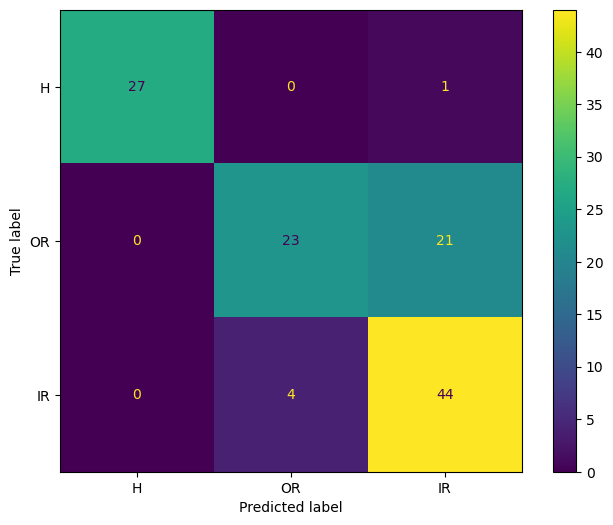

In [ ]:
# Validate and Visualize
tar = 0
fcase = 'tar3'
root_path = root + fcase + '/'
_, TestLoader, _, numClass = loaddata(root_path, tarData[0])
Model = torch.load('./saved_models/SqeezeNet_' + fcase+ '_' +tarData[0]+'.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader, numClass)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm, class_names)

perfSqeezeNet = {'Modelname':['SqeezeNet_'+ fcase+'_'+tarData[tar]], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

# **Plot Acc graph**

In [88]:
df = pd.read_excel('./results/train_hisy_pbu_T4_L1.xlsx')
df.head()

,Epochs,tr_vit,val_vit,tr_vit_pre,val_vit_pre,tr_effNet,val_effNet,tr_ResNeXt,val_ResNeXt,tr_DenseNet,val_DenseNet,tr_vgg16Net,val_vgg16Net,tr_GoogleNet,val_GoogleNet,tr_SqeezeNet,val_SqeezeNet
0,0,72.30,64.78,40.36,30.21,31.51,34.38,62.24,83.33,32.81,35.42,41.93,47.92,39.06,57.29,27.08,31.25
1,1,88.70,71.43,75.00,80.21,32.29,35.42,95.57,92.71,66.15,80.21,68.23,42.71,80.73,69.79,47.92,59.38
2,2,93.64,79.32,95.83,95.83,36.20,44.79,99.48,97.92,99.48,80.21,78.12,70.83,98.70,73.96,55.73,61.46
3,3,93.49,84.76,94.53,82.29,42.97,47.92,100.00,94.79,100.00,83.33,73.18,71.88,100.00,72.92,72.14,62.50
4,4,95.57,95.19,98.44,89.58,57.03,53.12,100.00,97.92,100.00,82.29,79.69,80.21,100.00,75.00,75.00,76.04


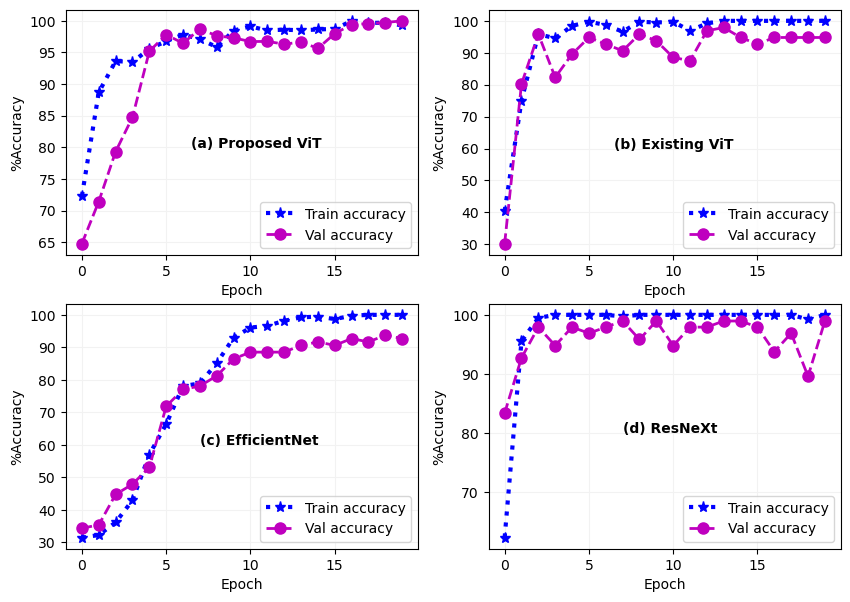

In [35]:
# df = pd.read_excel('train_hisy_vit_prop.xlsx')
fig = plt.figure(figsize=(10,7))
plt.subplot(2, 2, 1)
plt.plot(df['tr_vit'].values, 'b:*', linewidth=3, ms = 8)
plt.plot(df['val_vit'].values, 'm--o', linewidth=2, ms = 8)
# plt.title('trainin')
plt.ylabel('%CA')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Val accuracy'])
plt.text(6.5, 80, '(a) Proposed ViT', weight = 'bold')
plt.grid(axis='both', color='0.95')

plt.subplot(2, 2, 2)
plt.plot(df['tr_vit_pre'].values, 'b:*', linewidth=3, ms = 8)
plt.plot(df['val_vit_pre'].values, 'm--o', linewidth=2, ms = 8)
# plt.title('trainin')
plt.ylabel('%CA')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Val accuracy'])
plt.text(6.5, 60, '(b) Existing ViT', weight = 'bold')
plt.grid(axis='both', color='0.95')

plt.subplot(2, 2, 3)
plt.plot(df['tr_effNet'].values, 'b:*', linewidth=3, ms = 8)
plt.plot(df['val_effNet'].values, 'm--o', linewidth=2, ms = 8)
# plt.title('trainin')
plt.ylabel('%CA')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Val accuracy'])
plt.text(7.0, 60, '(c) EfficientNet', weight = 'bold')
plt.grid(axis='both', color='0.95')

plt.subplot(2, 2, 4)
plt.plot(df['tr_ResNeXt'].values, 'b:*', linewidth=3, ms = 8)
plt.plot(df['val_ResNeXt'].values, 'm--o', linewidth=2, ms = 8)
# plt.title('trainin')
plt.ylabel('%Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Val accuracy'])
plt.text(7.0, 80, '(d) ResNeXt', weight = 'bold')
plt.grid(axis='both', color='0.95')

fig.savefig("./img/acc_T4_L1.pdf")
plt.show()

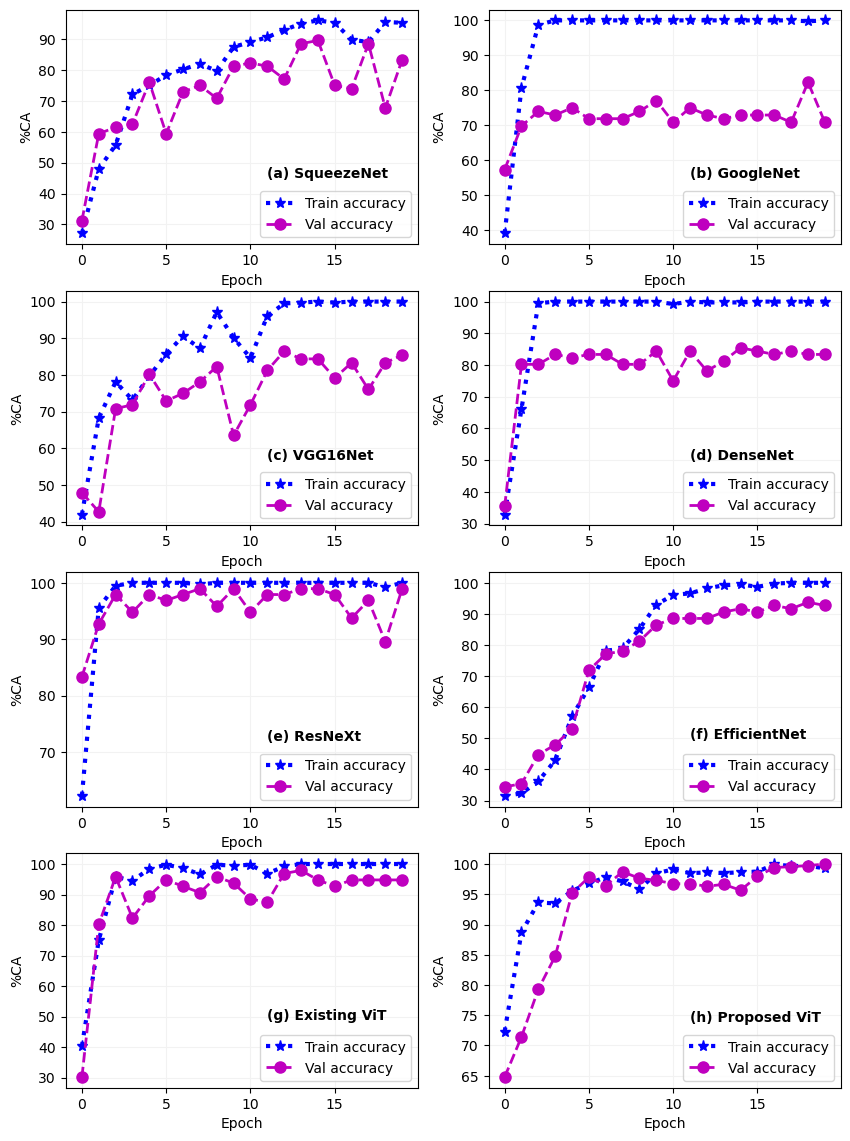

In [4]:
df = pd.read_excel('./results/train_hisy_pbu_T4_L1.xlsx')
fig = plt.figure(figsize=(10,14))
plt.subplot(4, 2, 8)
plt.plot(df['tr_vit'].values, 'b:*', linewidth=3, ms = 8)
plt.plot(df['val_vit'].values, 'm--o', linewidth=2, ms = 8)
# plt.title('trainin')
plt.ylabel('%CA')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Val accuracy'])
plt.text(11, 74, '(h) Proposed ViT', weight = 'bold')
plt.grid(axis='both', color='0.95')

plt.subplot(4, 2, 7)
plt.plot(df['tr_vit_pre'].values, 'b:*', linewidth=3, ms = 8)
plt.plot(df['val_vit_pre'].values, 'm--o', linewidth=2, ms = 8)
# plt.title('trainin')
plt.ylabel('%CA')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Val accuracy'])
plt.text(11, 49, '(g) Existing ViT', weight = 'bold')
plt.grid(axis='both', color='0.95')

plt.subplot(4, 2, 6)
plt.plot(df['tr_effNet'].values, 'b:*', linewidth=3, ms = 8)
plt.plot(df['val_effNet'].values, 'm--o', linewidth=2, ms = 8)
# plt.title('trainin')
plt.ylabel('%CA')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Val accuracy'])
plt.text(11, 50, '(f) EfficientNet', weight = 'bold')
plt.grid(axis='both', color='0.95')

plt.subplot(4, 2, 5)
plt.plot(df['tr_ResNeXt'].values, 'b:*', linewidth=3, ms = 8)
plt.plot(df['val_ResNeXt'].values, 'm--o', linewidth=2, ms = 8)
# plt.title('trainin')
plt.ylabel('%CA')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Val accuracy'])
plt.text(11.0, 72, '(e) ResNeXt', weight = 'bold')
plt.grid(axis='both', color='0.95')

plt.subplot(4, 2, 4)
plt.plot(df['tr_DenseNet '].values, 'b:*', linewidth=3, ms = 8)
plt.plot(df['val_DenseNet '].values, 'm--o', linewidth=2, ms = 8)
# plt.title('trainin')
plt.ylabel('%CA')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Val accuracy'])
plt.text(11.0, 50, '(d) DenseNet', weight = 'bold')
plt.grid(axis='both', color='0.95')

plt.subplot(4, 2, 3)
plt.plot(df['tr_vgg16Net'].values, 'b:*', linewidth=3, ms = 8)
plt.plot(df['val_vgg16Net'].values, 'm--o', linewidth=2, ms = 8)
# plt.title('trainin')
plt.ylabel('%CA')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Val accuracy'])
plt.text(11.0, 57, '(c) VGG16Net', weight = 'bold')
plt.grid(axis='both', color='0.95')

plt.subplot(4, 2, 2)
plt.plot(df['tr_GoogleNet'].values, 'b:*', linewidth=3, ms = 8)
plt.plot(df['val_GoogleNet'].values, 'm--o', linewidth=2, ms = 8)
# plt.title('trainin')
plt.ylabel('%CA')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Val accuracy'])
plt.text(11.0, 55, '(b) GoogleNet', weight = 'bold')
plt.grid(axis='both', color='0.95') 

plt.subplot(4, 2, 1)
plt.plot(df['tr_SqeezeNet'].values, 'b:*', linewidth=3, ms = 8)
plt.plot(df['val_SqeezeNet'].values, 'm--o', linewidth=2, ms = 8)
# plt.title('trainin')
plt.ylabel('%CA')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Val accuracy'], loc='lower right' )
plt.text(11.0, 45, '(a) SqueezeNet', weight = 'bold')
plt.grid(axis='both', color='0.95') 

fig.savefig("./img/acc_T4_L1.pdf", bbox_inches = 'tight', pad_inches = 0.05)
plt.show()

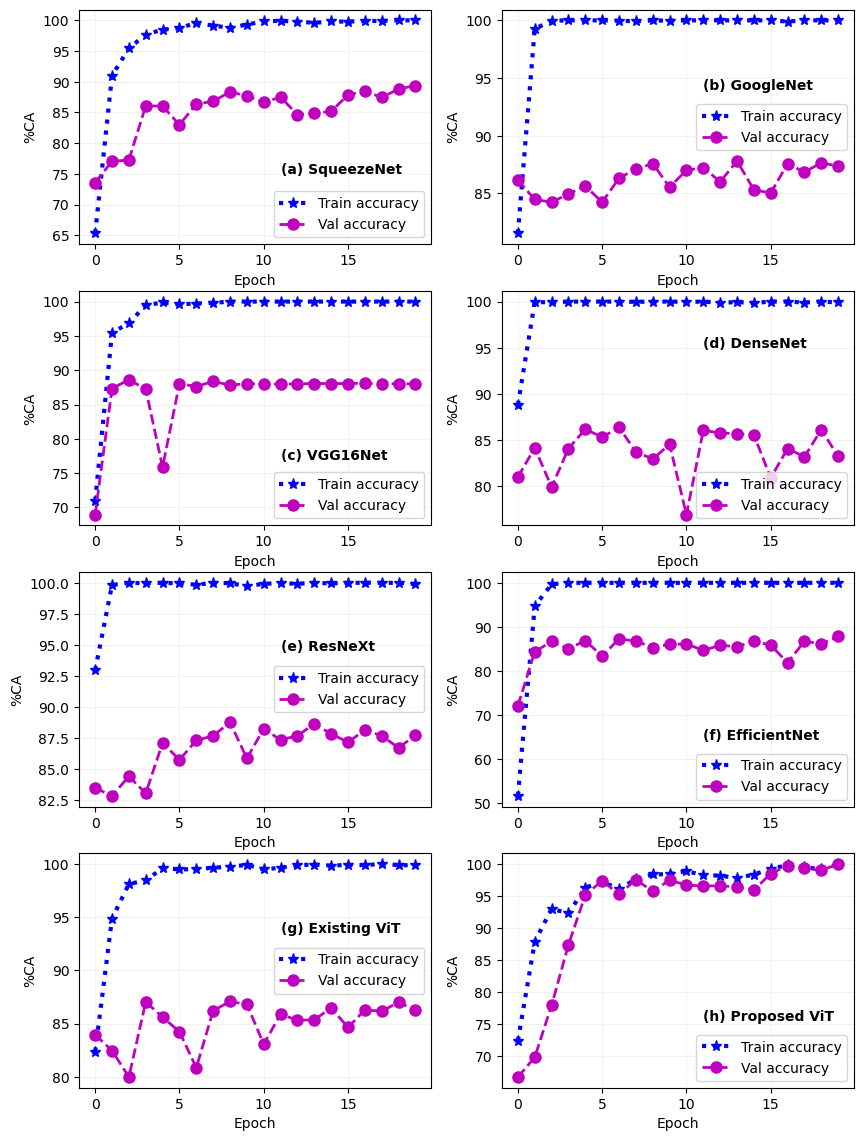

In [5]:
df = pd.read_excel('./results/train_hisy_bio_bCell.xlsx')
fig = plt.figure(figsize=(10,14))
plt.subplot(4, 2, 8)
plt.plot(df['tr_vit'].values, 'b:*', linewidth=3, ms = 8)
plt.plot(df['val_vit'].values, 'm--o', linewidth=2, ms = 8)
plt.ylabel('%CA')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Val accuracy'])
plt.text(11, 75.5, '(h) Proposed ViT', weight = 'bold')
plt.grid(axis='both', color='0.95')

plt.subplot(4, 2, 7)
plt.plot(df['tr_vit_pre'].values, 'b:*', linewidth=3, ms = 8)
plt.plot(df['val_vit_pre'].values, 'm--o', linewidth=2, ms = 8)
# plt.title('trainin')
plt.ylabel('%CA')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Val accuracy'], loc = 'center right')
plt.text(11, 93.5, '(g) Existing ViT', weight = 'bold')
plt.grid(axis='both', color='0.95')

plt.subplot(4, 2, 6)
plt.plot(df['tr_effNet'].values, 'b:*', linewidth=3, ms = 8)
plt.plot(df['val_effNet'].values, 'm--o', linewidth=2, ms = 8)
# plt.title('trainin')
plt.ylabel('%CA')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Val accuracy'])
plt.text(11, 64.5, '(f) EfficientNet', weight = 'bold')
plt.grid(axis='both', color='0.95')

plt.subplot(4, 2, 5)
plt.plot(df['tr_ResNeXt'].values, 'b:*', linewidth=3, ms = 8)
plt.plot(df['val_ResNeXt'].values, 'm--o', linewidth=2, ms = 8)
# plt.title('trainin')
plt.ylabel('%CA')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Val accuracy'], loc = 'center right')
plt.text(11.0, 94.5, '(e) ResNeXt', weight = 'bold')
plt.grid(axis='both', color='0.95')

plt.subplot(4, 2, 4)
plt.plot(df['tr_DenseNet '].values, 'b:*', linewidth=3, ms = 8)
plt.plot(df['val_DenseNet '].values, 'm--o', linewidth=2, ms = 8)
# plt.title('trainin')
plt.ylabel('%CA')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Val accuracy'])
plt.text(11.0, 95, '(d) DenseNet', weight = 'bold')
plt.grid(axis='both', color='0.95')

plt.subplot(4, 2, 3)
plt.plot(df['tr_vgg16Net'].values, 'b:*', linewidth=3, ms = 8)
plt.plot(df['val_vgg16Net'].values, 'm--o', linewidth=2, ms = 8)
# plt.title('trainin')
plt.ylabel('%CA')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Val accuracy'])
plt.text(11.0, 77, '(c) VGG16Net', weight = 'bold')
plt.grid(axis='both', color='0.95')

plt.subplot(4, 2, 2)
plt.plot(df['tr_GoogleNet'].values, 'b:*', linewidth=3, ms = 8)
plt.plot(df['val_GoogleNet'].values, 'm--o', linewidth=2, ms = 8)
plt.ylabel('%CA')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Val accuracy'])
plt.text(11.0, 94, '(b) GoogleNet', weight = 'bold')
plt.grid(axis='both', color='0.95') 

plt.subplot(4, 2, 1)
plt.plot(df['tr_SqeezeNet'].values, 'b:*', linewidth=3, ms = 8)
plt.plot(df['val_SqeezeNet'].values, 'm--o', linewidth=2, ms = 8)
plt.ylabel('%CA')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Val accuracy'], loc='lower right' )
plt.text(11.0, 75, '(a) SqueezeNet', weight = 'bold')
plt.grid(axis='both', color='0.95') 

fig.savefig("./img/acc_bCell.pdf", bbox_inches = 'tight', pad_inches = 0.05)
plt.show()